# Social Media Data Analytics Project <br>

<ul>
    <li> Student:  Andrew R. Darnall </li>
    <li> Matricola: 1000026223 </li>
    <li> Anno Accademico: 2022/2023 </li>
    <li> Corso:  Social Media Management - 6 CFU </li>
</ul>
<br>
<a href="https://www.kaggle.com/competitions/store-sales-time-series-forecasting" target="_blank"> Kaggle reference

#### Obiettivo del progetto

Effettuare un confronto predittivo tra due (o più) modelli in merito alla Time Series Forecasting.
In questo notebook e' presente training e testing con vari modelli della challenge di kaggle presente nel link sopra
citato.

I modelli usati, in ordine sono:

<ol>
    <li>Regressore Polinomiale</li>
    <li>MLP</li>
    <li>ARIMA</li>
    <li>LSTM</li>
</ol>

### Informazioni sul dataset

Il dataset reperito dal link trovato in precedenza e' un export di una base di dati che contiene tutte le vendite effettuate dalla catena di prodotti sud americana, con tali dati possono essere effettuate varie analisi tra cui time series forecasting.

### Pre processing

I dati richiedono un preprocessing per scremare i dati non richesti riducendo il numero di features a 1 ovvero quello delle vendite, indicizzando il dataframe restante con le date.

Per effettuare tale pre-processing ho usato una aggregazione del dataframe in base alle vendite effettuate quotidianamente da tutti i negozi in quanto esse sono riportate nel dataset in base al negozio in cui la vendita e' stata effettuata.

### Scelta dei modelli

I modelli in alisi sono stati scelti in quanto la regressione consiste in una baseline di performance, essendo il modello padre per previsioni relativamente semplici mentre l'utilizzo di ARIMA e Reti Neurali Artificiali sono i piu' utilizzati per effettuare Time Series Forecasting

### Piattaforma e ambiente

Ho scelto di svolgere il progetto nella piattaforma Google Colab in quanto offre un ottimo environment configurato ad-hoc per training di reti neurali, parallelizando a dovere le computazioni dovute.

### Avviso

Alcune porzioni di codice sono state commentate in quanto in questo progetto risiede tutto il codice usato per il progetto, training e tuning di hyper parametri inclusi

### Pre-processing del dataset

In [524]:
# In questa porzione di codice sto effettuando il mount del google drive dove si trova il dataset, in particolare il file: train.csv
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [525]:
# In questa porzione includo alcune delle librerie piu' importanti che utilizzero', tra cui:
# Pandas per i DataFrames
# Numpy per le computazioni algebriche e numeriche
# Matplotlib per il plotting dei grafici, sebbene gli oggetti DataFrame abbiano il metodo plot() integrato
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [526]:
# Una volta importato il dataset, questo e' il suo formato 'raw'
df = pd.read_csv("/content/drive/MyDrive/train.csv", parse_dates=True, index_col='date')
df.head()

id  store_nbr      family  sales  onpromotion
date                                                     
2013-01-01   0          1  AUTOMOTIVE    0.0            0
2013-01-01   1          1   BABY CARE    0.0            0
2013-01-01   2          1      BEAUTY    0.0            0
2013-01-01   3          1   BEVERAGES    0.0            0
2013-01-01   4          1       BOOKS    0.0            0

In [527]:
# Essendoci molte informazioni che esulano dallo scopo del progetto, tra cui la tipologia di prodotti, il numero di negozio, l'id e qualora siano in promozione o meno
# Effettuo il drop di tali colonne (non modificando il dataset originale)
df = df.drop(['id','store_nbr','family','onpromotion'], axis=1)
# Essendo le vendite distribuite tra i vari negozi della catena, effettuo una operazione aggregata, nonche' una groupby
# dove aggrego tutte le vendite effettuate mediante la giornata da tutti i negozi della catena alimentare
df = df.groupby('date').sum()
# Effettuo un'operazione di flooring per arrotondare i valori
df = df['sales'].apply(np.floor)
df.head()

date
2013-01-01      2511.0
2013-01-02    496092.0
2013-01-03    361461.0
2013-01-04    354459.0
2013-01-05    477350.0
Name: sales, dtype: float64

In [528]:
# Qui eseguo una copia del dataframe per effettuare facilmente operazioni in futuro
ndf = pd.DataFrame(df)

In [529]:
# Qui importo l'oggetto seasonal_decompose, un'utilissimo oggetto atto alla decomposizione in componenti della serie temporale
# Nonche' il trend, la stagionalita' ed il residuo, inoltre e' utile per studiare i dati che sia hanno a disposizione qualora
# Non fossero state esplicitate le analisi eseguibili sul dataset
from statsmodels.tsa.seasonal import seasonal_decompose

In [530]:
# Con questa operazione effettuo un resample delle vendite per avere una frequenza quotidiana esplicita altrimenti 
# fallirebbe l'utilizzo dell'oggetto seasonal_decompose
result = ndf['sales'].resample('D').sum()

In [531]:
# Qui creo prima un index range che successivamente aggiungero' ai dati 'resampled' nella cella precedente
# Creando il dataframe components, che usero' per plottare le componenti della Time Series
index = pd.date_range(start='2013-01-01', end='2017-08-15', freq='D')
comp = pd.DataFrame(index=index,data={'sales':result.values})
components = seasonal_decompose(comp['sales'],model='additive')

Ho usato l'oggetto seasonal_decompose per scomporre e cogliere meglio la serie temporale, tuttavia questo e' un overview lungo i mesi di 4 anni, il task kaggle richiede un forecast di 15 giorni dunque processero' i dati per ottenere dati con frequenza quotidiana.

In [532]:
# Partiziono il dataset in anni separati per visualizzare l'evoluzione delle varie componenti lungo gli anni
year_2013 = comp[:364]
year_2014 = comp[365:729]
year_2015 = comp[730:1094]
year_2016 = comp[1095:1459]
year_2017 = comp[1460:]

In [533]:
# Qui estraggo il risultato dell'oggetto seasonal_decompose, usando il modello additivo, tale modello
# Suppone che la serie sia una somma delle tre componenti principali, p,d,q, (trend, stragionalita' e variazioni residue/random residual fluctiations)
comp_2013 = seasonal_decompose(year_2013['sales'],model='additive')
comp_2014 = seasonal_decompose(year_2014['sales'],model='additive')
comp_2015 = seasonal_decompose(year_2015['sales'],model='additive')
comp_2016 = seasonal_decompose(year_2016['sales'],model='additive')
comp_2017 = seasonal_decompose(year_2017['sales'],model='additive')

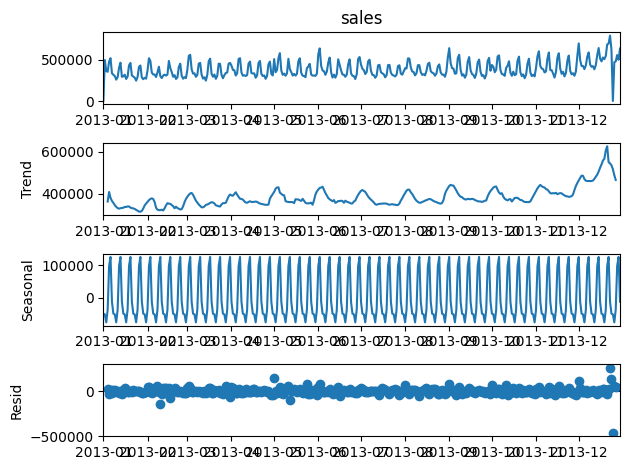

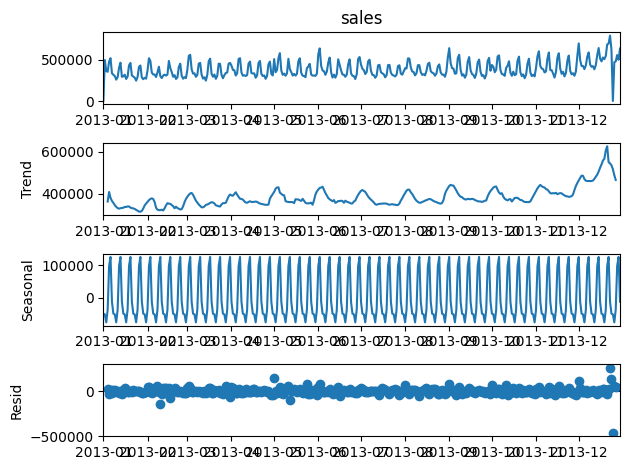

In [534]:
# Plottando i vari anni si conferma che i dati sono di fatto usabili per analisi di serie temporali e si evince dai grafici che i trend variano in tutti gli anni
# Subendo delle fluttuazioni in teressanti nel 2014
comp_2013.plot()

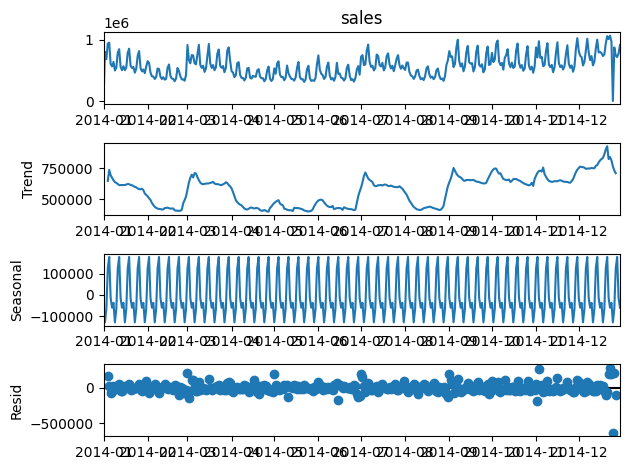

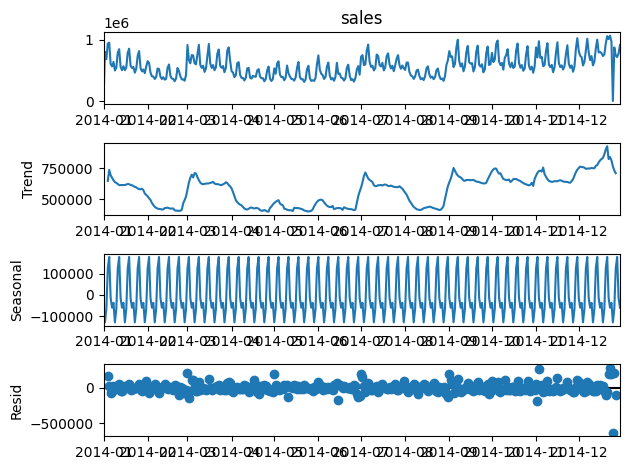

In [535]:
comp_2014.plot()

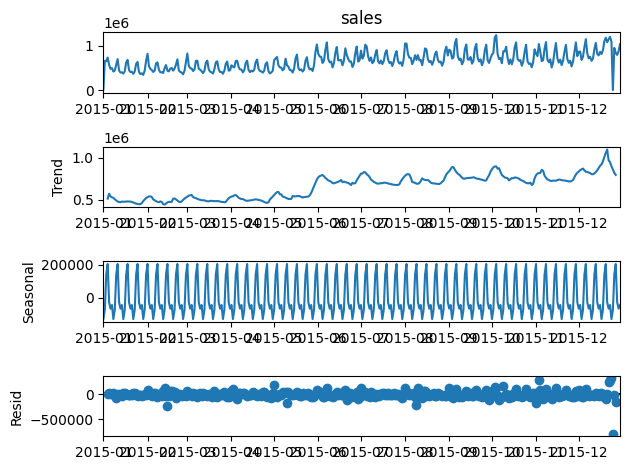

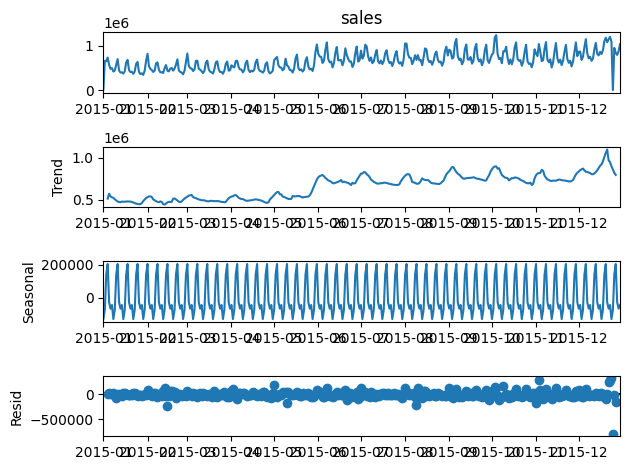

In [536]:
comp_2015.plot()

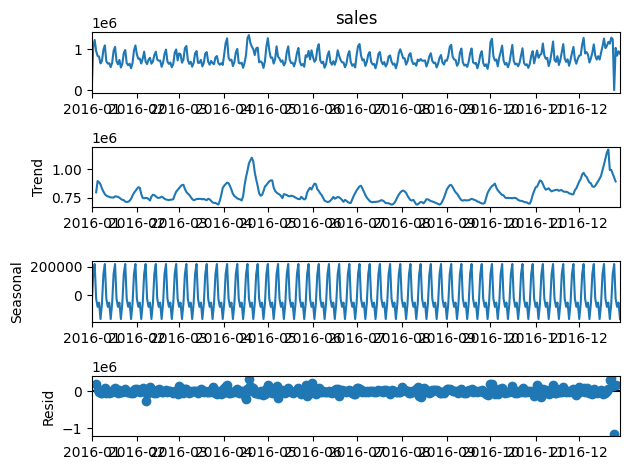

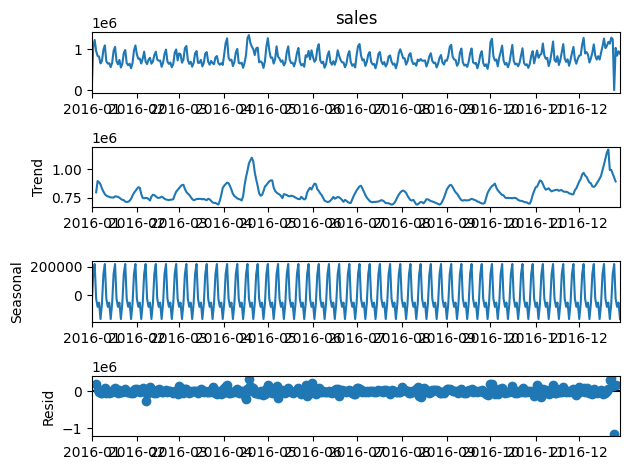

In [537]:
comp_2016.plot()

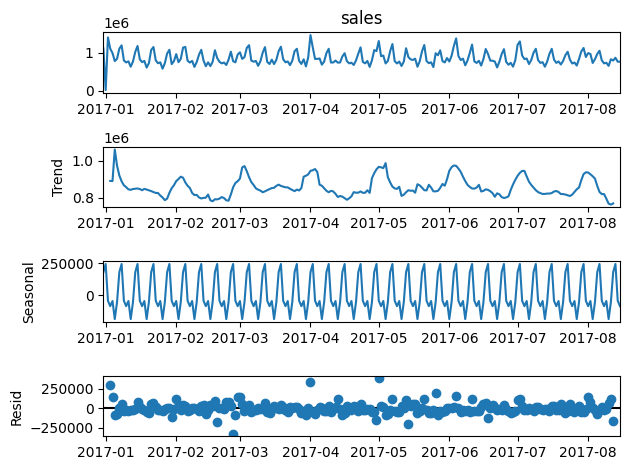

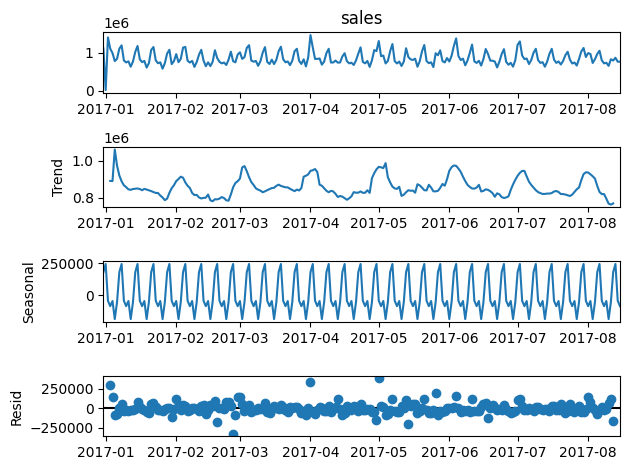

In [538]:
comp_2017.plot()

Entrambi il 2013 e 2017 presentano dei trends interessanti, tuttavia per applicare un regressore in maniera
sensata devo tramutare i dati in finestre temporali ed associare tali finestre a dei valori di output
in modo tale che in base ai valori presi in input (la finestra temporale) il regressore possa predirre
in maniera appropriata il forecast, ripetendo tale operazione windowed 15 volte  integrando il nuovo valore
predetto e scartando dalla finestra il valore piu' vecchio, otterro' il forecast dei giorni richiesti

## Regression

E' possibile che un regressore lineare possa performare bene in base alla natura dei dati, tuttavia, di norma
i regressori polinomiali colgono meglio la relazione tra i dati.

In [539]:
# Prima di poter applicare qualsiasi modello, occorre effettuare un'ultima transformazione dei dati ovvero trasformarli in finestre temporali + l'output per cui fare il forecast
# Dunque prendero' N valori, di cui N - 1 saranno parte della finestra di input e il valore N sara' l'output di tale finestra, o il valore che viene dopo, facendo cio'
# Posso effettuare forecasts adeguati e facilmente 'fittable', in base a quanto studiato, questo e' l'unico modo per effettuare forecasts per Time Series

# Qui partiziono il dataset in training e test set
train = comp[:1200]
test = comp[1200:]

### Min-Max scaler

Ho utilizzato un Min-Max scaler per effettuare uno scaling dei dati per avere un bias minore in quanto il trend delle vendite puo' essere rimasto invariato sebbene la cardinalita' di queste ultime sia aumentata.

Di fatto min-max scaling e' una pratica standard quando si approccia la Time Series Forecasting

In [540]:
# Uso un min-max scaler per potare le vendite su una scala relativa
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Effettuo il fit dello scaler
scaler.fit(train)

MinMaxScaler()

In [541]:
# E ottengo le nuove partizioni dei dati 'scalati'
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

### Time Series Generator

Ho usato tale oggetto per creare delle tuple input/output in quanto per effettuare delle previsioni accurate, sono ricorso all'utilizzo di operazioni windowed, ovvero ho preso alcuni dati temporali (ordinati) ed ottenuto in output il dato da prevedere, facendo in modo che il modello effettui un fit in maniera accurata.

Anche questa pratica e' prassi per il Time Series Forecasting.

In [542]:
# Con il TimeSeriesGenerator creo le coppie input/output, ovvero 12 giorni(input) 13^ giorno (output)
from keras.preprocessing.sequence import TimeseriesGenerator

# successivamente sono riportati i parametri che prende in input l'oggetto TimeSeriesGenerator
# Ho scelto di usare una finestra di input = 2, con n = 1 di features, ovvero la colonna sales 
# del data frame ndf, in quanto scikitlearn a problemi ad effettuare il fit con dimensionalita'
# maggiori di 2 (di fatto quando ho provato ha rammentato quanto detto)
n_input = 2
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [543]:
# Un elemento dell'oggetto generator
_input,_output = generator[0]

In [544]:
# Come e' visibile dall'output della cella, ho due campioni (ordinati) del dataset + l'output (_output)
# ovviamente tutti e tre i campioni della sequenza sono ordinati, lo stesso vale per gli altri
_input

array([[[0.00198199],
        [0.39157697]]])

In [545]:
_output

array([[0.28530959]])

In [546]:
# Separo queste tuple per poter effettuare il fitting del regressore
X_train = []
Y_train = []

for element in generator:
    e = element[0][0]
    t = (e[0][0],e[1][0])
    X_train.append(t)
    Y_train.append(element[1][0][0])
    
X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [547]:
# Importo il regressore lineare come primo modello ed effettuo un fit con i dati pre processati
from sklearn.linear_model import LinearRegression

linear_regressor = LinearRegression()
linear_regressor.fit(X_train, Y_train)

LinearRegression()

In [548]:
# Effettuo delle previsioni in base a quanto ottenuto dal modello
train_preds = linear_regressor.predict(X_train)

In [549]:
# Effettuo un reshaping dei dati per poter valutare l'errore del forecast in maniera assoluta
train_preds = train_preds.reshape(-1,1)
unscaled_predictions = scaler.inverse_transform(train_preds)

In [550]:
# Creo un data frame dove ho 2 colonne, la prima con i valori di ground truth (y) e la seconda con i valori predetti (y^ hat)
train_frame = train[2:]
train_frame['predictions'] = unscaled_predictions

In [551]:
# Con l'oggetto mean_absolute_error valuto la performance del modello sul training set
from sklearn.metrics import mean_absolute_error

MAE = mean_absolute_error(train[2:],unscaled_predictions)
print("Mean Absolute Error on training set:\t{:.3f}".format(MAE))

Mean Absolute Error on training set:	106037.577


<Axes: >

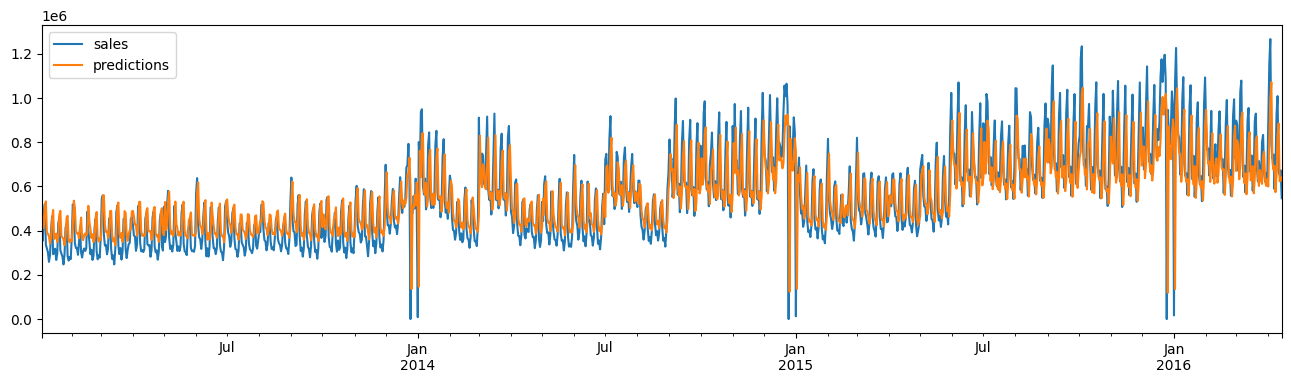

In [552]:
# Da tale grafico evinco che il fit non sia perfetto ma che  comunque il mdoello abbia appreso l'andamento della serie
# Qualora il fit fosse stato perfetto, cio' sarebbe stato un problema in quanto avrebbe indicato un over-fitting da parte del modello
# La performance vera e propria del modello verra' valutata sul test set, da li vedremo quanto sia capace il modello di generalizzare
train_frame.plot(figsize=(16,4))

In [553]:
# Ripeto lo stesso procedimento per il test set
generator = TimeseriesGenerator(scaled_test, scaled_test, length=n_input, batch_size=1)

X_test = []
Y_test = []

# Questo loop in particolare serve per effettuare delle conversioni di tipo affinche' siano compatibili con le chiamate dell'API
for element in generator:
    e = element[0][0]
    t = (e[0][0],e[1][0])
    X_test.append(t)
    Y_test.append(element[1][0][0])
    
X_test = np.array(X_test)
Y_test = np.array(Y_test)

test_preds = linear_regressor.predict(X_test)

test_preds = test_preds.reshape(-1,1)
unscaled_predictions = scaler.inverse_transform(test_preds)

test_frame = test[2:]
test_frame['predictions'] = unscaled_predictions

MAE_test = mean_absolute_error(test_frame['sales'],test_frame['predictions'])
print("Mean Absolute Error on test set:\t{:.3f}".format(MAE_test))

Mean Absolute Error on test set:	150520.541


Dunque comparando le perforamnce del Regressore Lineare con il training e test set, vediamo che il MAE su di essi e' rispettivamente: 106037.577 e 150520.541

<Axes: >

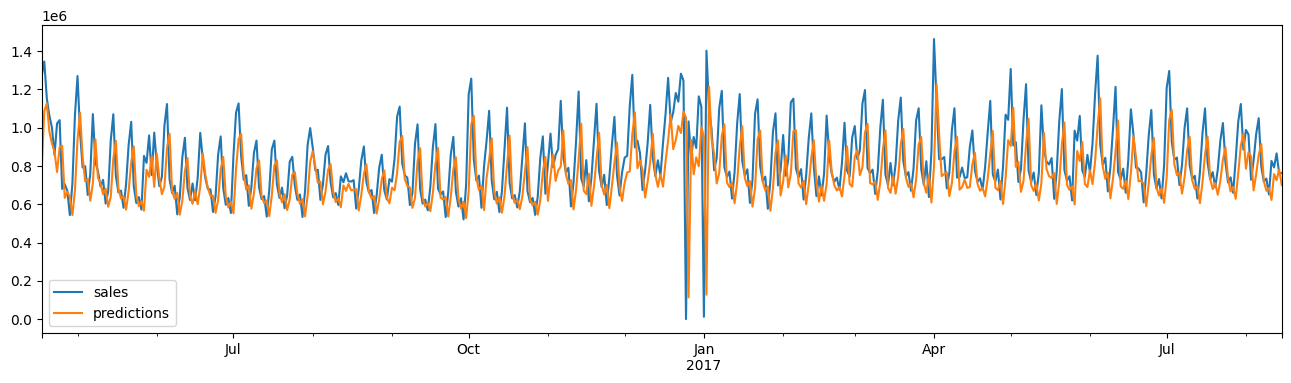

In [554]:
# Dal plot del test frame si evince che sebbene il MAE rispetto al training set sia aumentato, graficamente si evince che il fit non sia cosi pessimo
# Anzi, in maniera sorprendente performa in maniera notevolmente migliore rispetto a quanto credessi
test_frame.plot(figsize=(16,4))

In [555]:
print(len(forecast_predictions))

15


A questo punto per effettuare la previsione non posso piu' contare sull'oggetto TimeSeries per creare le coppie input/output dunque creo con un semplice ciclo for le previsioni per una determinata finestra temporale e prendo il primo forecast per ogni valore

In [556]:
# In questa cella effettuo l'effettivo forecast dove prednedno gli ultimi n-1 giorni, predico l'N esimo giorno, togliendo il primo giorno presente in questa
# finestra temporale e aggiungendo alla fine di quest'ultima, l'ultima previsione
# Da notare che prendo la prima previsione per ogni iterazione del ciclo
last_train_batch = scaled_test[-100:]

forecast_predictions = []
first_eval_batch = last_train_batch.reshape(50,2)

for i in range(8):
    current_pred = []
    current_pred.append(linear_regressor.predict(first_eval_batch)[0])
    current_pred.append(linear_regressor.predict(first_eval_batch)[1])
    forecast_predictions.append(current_pred)
    first_eval_batch = first_eval_batch[1:]
    first_eval_batch = np.concatenate((first_eval_batch, [current_pred]))

In [557]:
# Trasformo dal valore scalato ad un valore assoluto mediante l'inversa delle trasforma
true_predictions = scaler.inverse_transform(forecast_predictions)

In [558]:
# Effettuo una conversione di tipo del forecast
forecast = [item for tuple in true_predictions for item in tuple]
# Questo perche ci interessano solamente 15 giorni di forecast
forecast = forecast[:15]
print(forecast)

[669743.5930322642, 619475.2614856416, 619475.2614856416, 972574.9541941388, 972574.9541941388, 746749.9688921924, 746749.9688921924, 763308.9966255296, 763308.9966255296, 718682.3269983267, 718682.3269983267, 1027020.0599486787, 1027020.0599486787, 675183.7624963077, 675183.7624963077]


In [559]:
# In questa cella, invece, prendo solamente la porzione di agosto, del dataset, porzione che e' stata interrotta appositamente il 15 di agosto del 2017
august_df = ndf['2017-08-01':]

index = pd.date_range(start='2017-08-16', end='2017-08-30', freq='D')
f_pairs = pd.DataFrame(index=index, data={'sales':forecast})
linear_regressor_forecasted_df = pd.concat([august_df, f_pairs], ignore_index=True)

<Axes: >

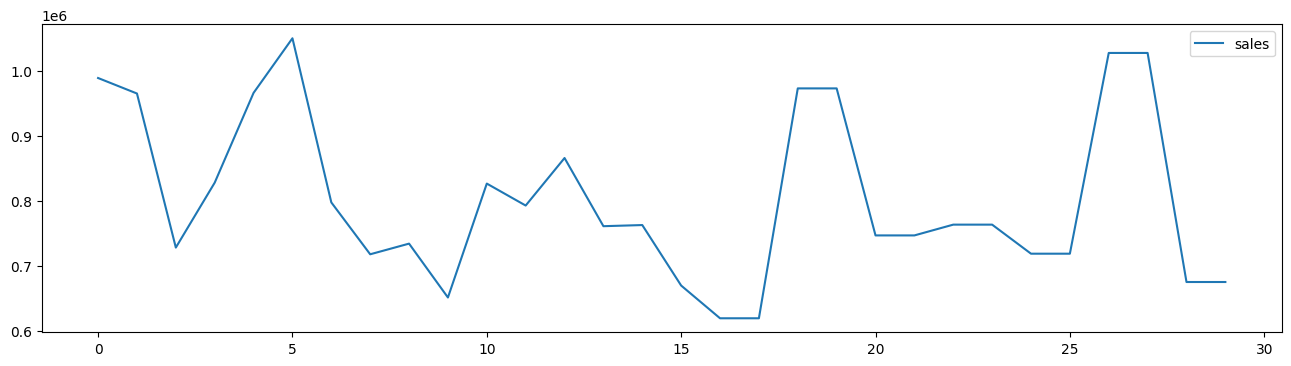

In [560]:
# In questo grafico si nota la strana curva della previsone ma questo e' dovuto all'implementazione di scikitlearn, ho notato che aumentando la frequenza della finestra temporale
# si ottengono risultati migliori
linear_regressor_forecasted_df.plot(figsize=(16,4))

Come si puo' osservare le previsioni ottenute con il regressore lineare non sono le migliori e nonostante un buon training esso ha difficolta' ad approssimare la funzione

#### Polynomial Regressor

Normalmente essendo i regressori lineari molto limitati si prediligono i regressori polinomiali, utilizando una regolarizazzione di tipo L2 per migliorare il fitting della curva polinomiale

La regolarization di tipo L2 consiste nell'aggiungere una penalita'
alla curva per evitare overfitting e promuovere la generalizazzione,
informalmente, evita che la curva polinomiale si 'espanda' troppo,
problema comune con la regressione polinomiale

In [561]:
# Importo l'oggetto PolynomialFeatures con cui creo le features polinomiali, l'oggetto Ridge per la ridge regression (con la regolarizzazione)
# GridSearchCV per effetturare una ricerca dei parametri ottimali del modello e la pipeline per unire gli oggetti PolynomialFeatures con Ridge
# per usarli con GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    PolynomialFeatures(),
    Ridge()
)

param_grid = {'polynomialfeatures__degree': np.arange(1,20),
    'ridge__alpha': [0.1, 1.0, 10.0]}
gs = GridSearchCV(pipeline, param_grid, cv=5)
gs.fit(X_train,Y_train)

gs.best_params_

{'polynomialfeatures__degree': 10, 'ridge__alpha': 0.1}

In [562]:
# In base all'output dell'oggetto GridSearchCV ho tarato il Ridge regressor e PolynomialFeatures
lr = Ridge(alpha=0.1)
pf = PolynomialFeatures(degree=10)

x_train_poly = pf.fit_transform(X_train)
lr.fit(x_train_poly,Y_train)
y_train_preds = lr.predict(x_train_poly)

y_train_preds = y_train_preds.reshape(-1,1)
unscaled_predictions = scaler.inverse_transform(y_train_preds)

poly_train_frame = train[2:]
poly_train_frame['predictions'] = unscaled_predictions

# Possiamo evincere che il regressore polinomiale ha una performance migliore rispetto al regressore lineare
MAE_train_poly = mean_absolute_error(train[2:],unscaled_predictions)
print("MAE on training set:\t{:.3f}".format(mean_absolute_error(train[2:],unscaled_predictions)))

MAE on training set:	96616.133


<Axes: >

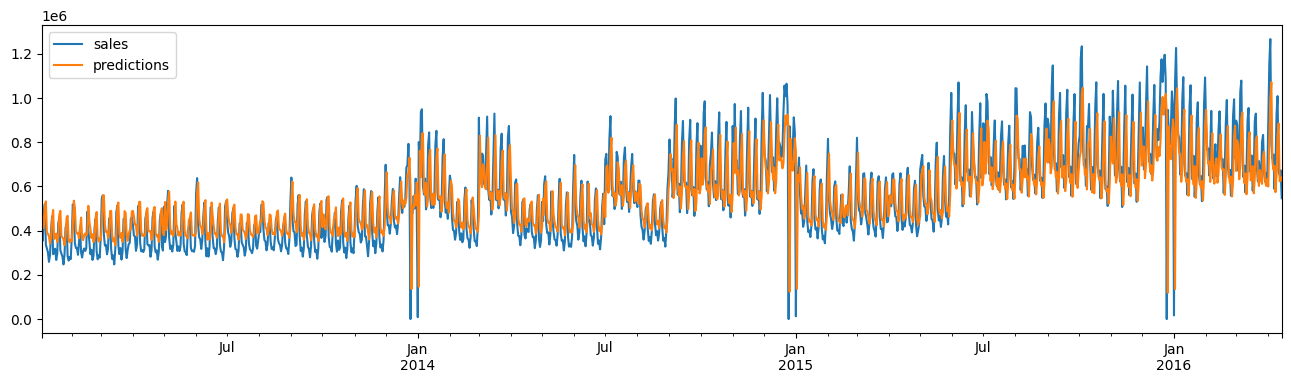

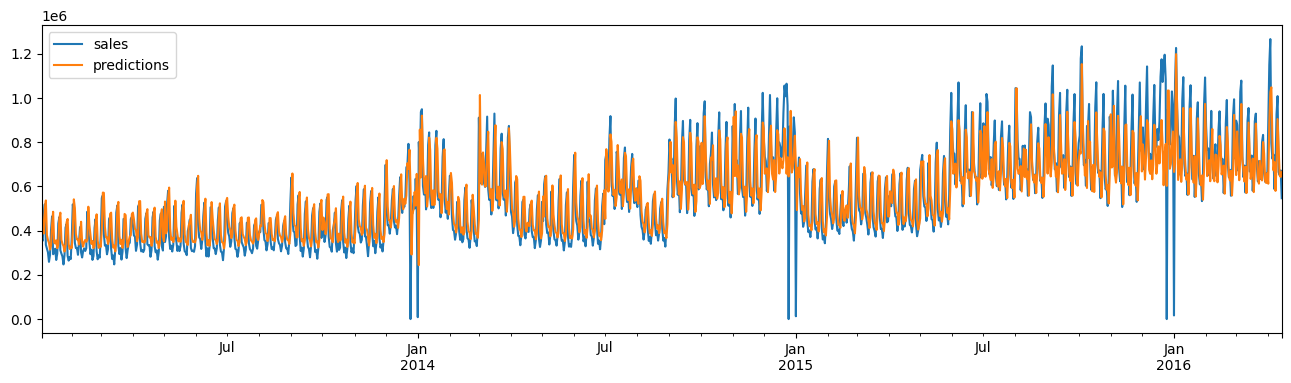

In [563]:
# Sebbene il regressore polinomiale abbia una performance lievemente migliore di quello lineare, tale effetto non e' facilmente notabile dal grafico del training set
train_frame.plot(figsize=(16,4))
poly_train_frame.plot(figsize=(16,4))

In [564]:
# Adesso procedo con il test set per vedere quanto sia in grado di generalizzare 
x_test_poly = pf.fit_transform(X_test)
lr.fit(x_test_poly,Y_test)
y_test_preds = lr.predict(x_test_poly)

y_test_preds = y_test_preds.reshape(-1,1)
unscaled_predictions = scaler.inverse_transform(y_test_preds)

poly_test_frame = test[2:]
poly_test_frame['predictions'] = unscaled_predictions

MAE_test_poly = mean_absolute_error(test[2:],unscaled_predictions)
print("MAE on test set:\t{:.3f}".format(mean_absolute_error(test[2:],unscaled_predictions)))

MAE on test set:	113249.581


Il regressore polinomiale generalizza lievemente in modo migliore rispetto al regressore lineare, infatti ha un MAE piu' basso rispetto al MAE del regressore lineare, che e' di 150520.541

<Axes: >

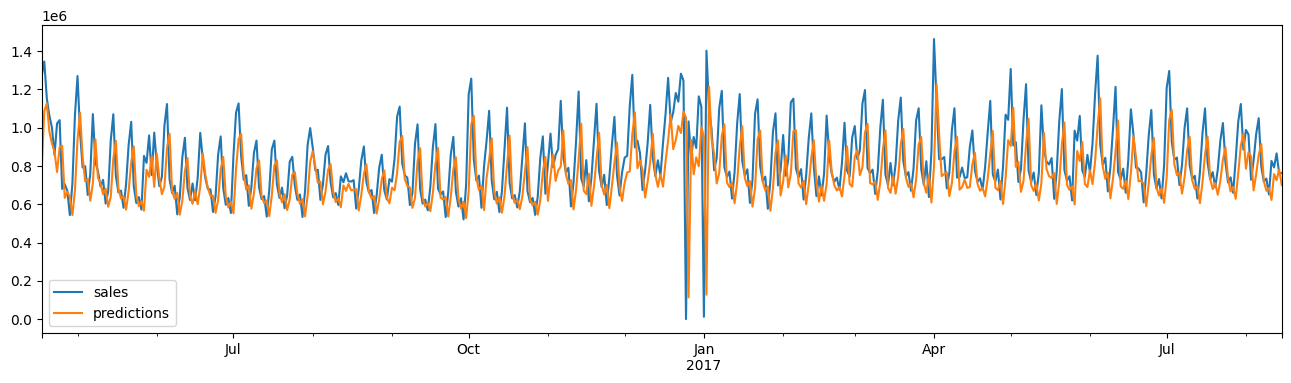

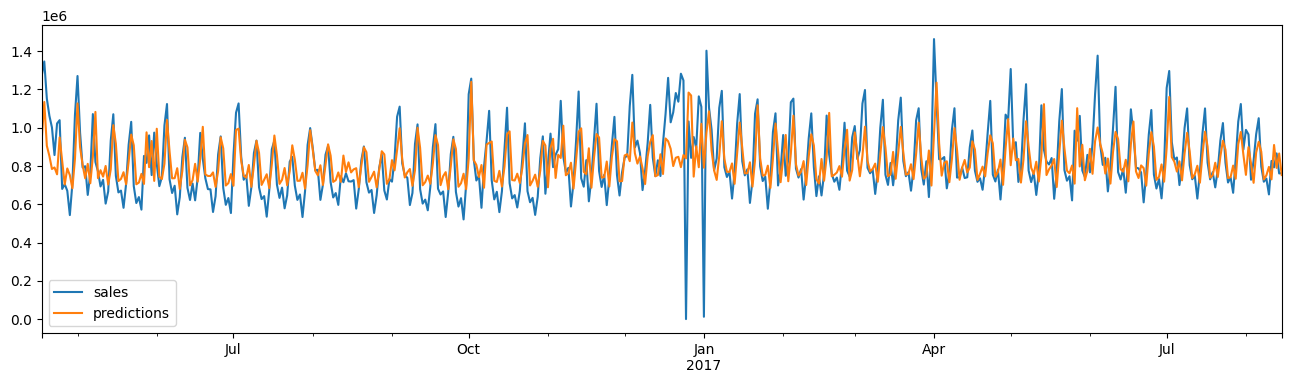

In [565]:
# Nel test set invece possiamo evincere una lieve differenza visuale rispetto al training e test set rispettivamente
test_frame.plot(figsize=(16,4))
poly_test_frame.plot(figsize=(16,4))

Conclusioni: notiamo un miglioramento nelle performance del forecasting da parte del regressore polinomiale tuttavia resta pur sempre un modello non ottimale vista la quantita' di danaro che viene persa.

## MLP model

Un approccio migliore al problema del Time Series Forecasting e' quello di utilizzare degli approssimatori universali ovvero delle Reti Neurali Artificiali come un Multi Layer Perceptron.

Tale modello e' una rete neurale di tipo feed foreward, dunque con architettura sequenziale dove possiamo modificare vari parametri tra cui il numero di neuroni, il numero di layers nascosti, funzione di loss, ottimizzatori e funzioni di attivazione, trovando un buon equilibrio tra questi parametri si ottiene un buon modello per tale task.

La sequenzialita' del modello e' intrensica all'API in utilizzo, ovvero scikit-learn, TensorFlow e PyTorch offrono invece molta piu' flessibilita' con le loro APIs, TensorFlow offer anche una functional API per costruire modelli molto complessi, a differenza di scikit-learn

In [566]:
# Importo il modello di Regressore MLP nello specifico in quanto l'oggetto adatto per il nostro scopo
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(verbose=True)

# Qui definisco una griglia di parametri per cui l'oggetto GridSearchCV trovera' i parametri ideali
# Tuttavia tale procedura richiede un tempo non indifferente (circa 1:30h con questa configurazione)
param_grid = {
    'hidden_layer_sizes': [(10,), (20,), (30,), (40,), (50,),(60), (10,2), (20,2), (30,2), (40,2), (50,2),(60,2), (10,3), (20,3), (30,3), (40,3), (50,3),(60,3), (10,4), (20,4), (30,4), (40,4), (50,4),(60,4),
     (10,5), (20,5), (30,5), (40,5), (50,5),(60,5),(10,6), (20,6), (30,6), (40,6), (50,6),(60,6)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}


In [567]:
# Ricarico i dati in fomato tuple input/output
n_input = 2
n_features = 1

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

X_train = []
Y_train = []

for element in generator:
    e = element[0][0]
    t = e[0][0]
    X_train.append(t)
    Y_train.append(element[1][0][0])
    
X_train = np.array(X_train)
Y_train = np.array(Y_train)


X_train = X_train.reshape(599,2)
Y_train = Y_train.reshape(599,2)

n_input = 2
n_features = 1

generator = TimeseriesGenerator(scaled_test, scaled_test, length=n_input, batch_size=1)

X_test = []
Y_test = []

for element in generator:
    e = element[0][0]
    t = e[0][0]
    X_test.append(t)
    Y_test.append(element[1][0][0])
    
X_test = np.array(X_test)
Y_test = np.array(Y_test)

X_test = X_test.reshape(243,2)
Y_test = Y_test.reshape(243,2)

print("X_Train.shape:\t{} - Y_Train.shape:\t{}".format(X_train.shape,Y_train.shape))

X_Train.shape:	(599, 2) - Y_Train.shape:	(599, 2)


In [568]:
# Qui definisco l'oggetto GridSearchCV che controllera' i parametri ideali
grid_search = GridSearchCV(mlp, param_grid, cv=5, verbose=True)

In [569]:
# Questa chiamata di metodo effettua il fit dei parametri, resta commentata poiche' una volta trovati i parametri ideali e' futile ri-effettuare il fit
# Cosa che non succede invece con il modello LSTM in quanto esso deve solo effettuare il training del modello
# grid_search.fit(X_train,Y_train)

In [570]:
# I parametri e modello ottimale sono contenuti in queste variabili ottenute dall'oggetto GridSearchCV
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

In [571]:
# Di seguito ho riportato i parametri migliori ottenuti dal (lunghissimo) fit

# These are the best parameters that I found from GridSearchCV for the model
#{'activation': 'relu',
# 'alpha': 0.001,
# 'hidden_layer_sizes': (10,),
# 'learning_rate': 'adaptive',
# 'solver': 'lbfgs'}

In [572]:
# best_model

In [573]:
# Adesso resta solamente la definizione del modello ed il suo effettivo fit con i parametri ideali
mlp = MLPRegressor(activation='relu', alpha=0.001, hidden_layer_sizes=(10,), learning_rate='adaptive',solver='lbfgs')

In [574]:
mlp.fit(X_train,Y_train)

MLPRegressor(alpha=0.001, hidden_layer_sizes=(10,), learning_rate='adaptive',
             solver='lbfgs')

In [575]:
# Questa e' la loss (scalata) sul training set
mlp.loss_

0.008089843605817675

In [576]:
# Qui effettuo le stesse operazioni fatte in precendeza per l'API specifico
mlp_train_preds = mlp.predict(X_train)
mlp_train_preds = mlp_train_preds.reshape(1198,)
mlp_train_preds = mlp_train_preds.tolist()
mlp_train_preds = np.array(mlp_train_preds)

mlp_train_preds = mlp_train_preds.reshape(-1,1)
unscaled_predictions = scaler.inverse_transform(mlp_train_preds)

mlp_train_frame = train[2:]
mlp_train_frame['predictions'] = unscaled_predictions

MAE_mlp_train = mean_absolute_error(train[2:],unscaled_predictions)
print("MAE on training set:\t{:.3f}".format(mean_absolute_error(train[2:],unscaled_predictions)))

MAE on training set:	121157.571


Sorprendentemente si evince che il modello ottenuto performa in maniera peggiore di un regressore polinomiale

<Axes: >

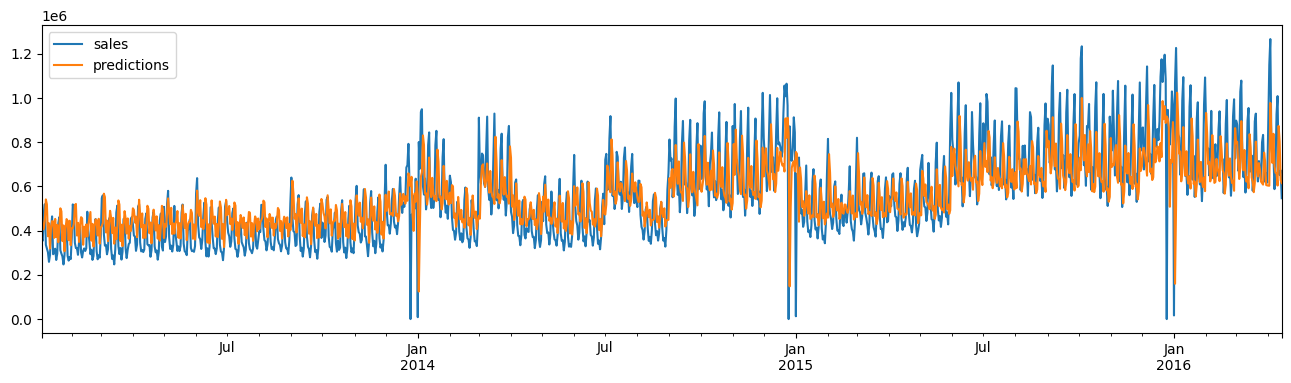

In [577]:
# Notiamo immediatamente dal grafico che il fit e' peggiore rispetto ai regressori
mlp_train_frame.plot(figsize=(16,4))

In [578]:
# Adesso effettuo le medesime operazioni con il test set
mlp_test_preds = mlp.predict(X_test)
mlp_test_preds = mlp_test_preds.reshape(486,)
mlp_test_preds = mlp_test_preds.tolist()
mlp_test_preds = np.array(mlp_test_preds)

# Y_test = Y_test.reshape(486,)

mlp_test_preds = mlp_test_preds.reshape(-1,1)
unscaled_predictions = scaler.inverse_transform(mlp_test_preds)

mlp_test_frame = test[2:]
mlp_test_frame['predictions'] = unscaled_predictions

MAE_mlp_test = mean_absolute_error(test[2:],unscaled_predictions)
print("MAE on test set:\t{:.3f}".format(mean_absolute_error(test[2:],unscaled_predictions)))

MAE on test set:	161654.320


Si nota anche per il test set che l'MLP performa in maniera peggiore rispetto al regressore lineare, che ha un MAE di 150520.541, rispetto al MAE dell'MLP che e' 159658.315

<Axes: >

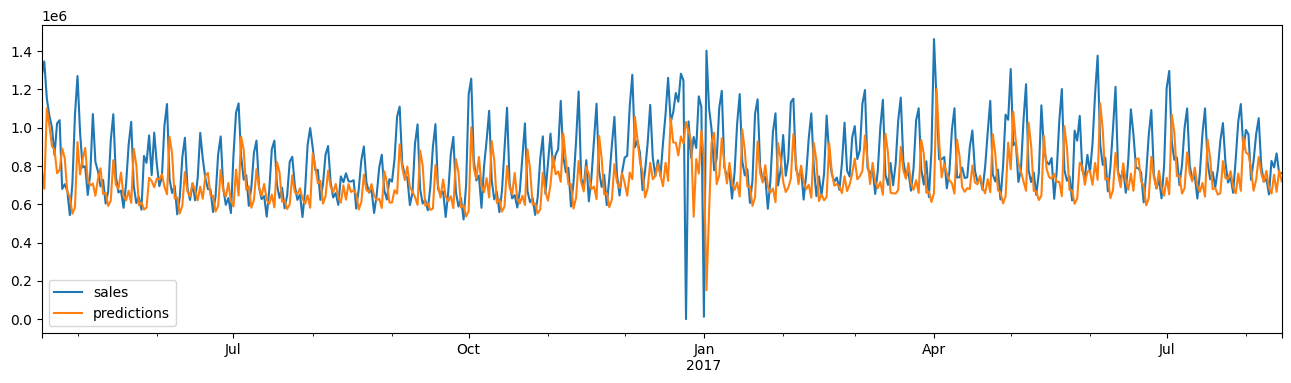

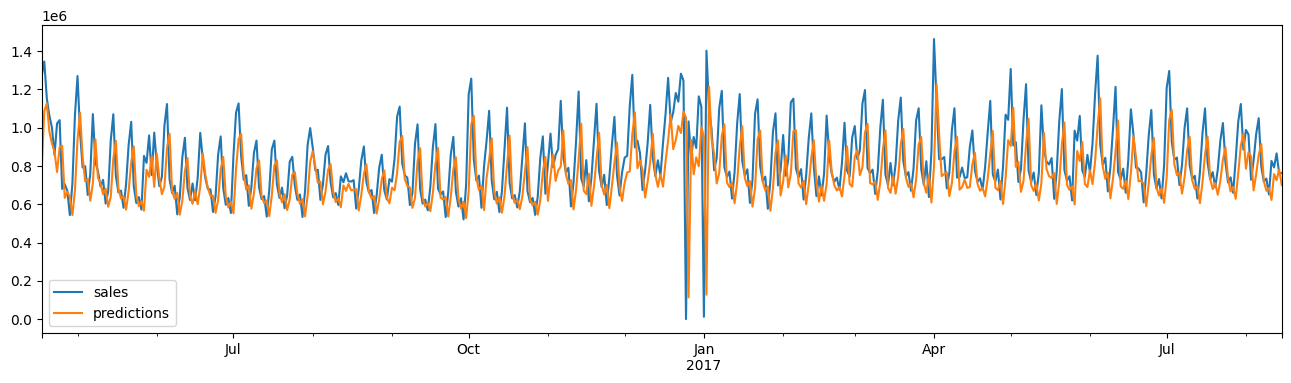

In [579]:
# Anche da questo grafico si evince visivamente quanto peggiormente ha performato rispetto al regressore lineare
# Il primo grafico e' dell'MLP mentre il secondo del regressore lineare
mlp_test_frame.plot(figsize=(16,4))
test_frame.plot(figsize=(16,4))

In [580]:
# Adesso effettuo il forecast con l'MLP
first_eval_batch = X_test[-12:]

forecast_predictions = []

for i in range(15):
    current_pred = []
    current_pred.append(mlp.predict(first_eval_batch)[0][0])
    current_pred.append(mlp.predict(first_eval_batch)[1][0])
    forecast_predictions.append(current_pred)
    first_eval_batch = first_eval_batch[1:]
    first_eval_batch = np.concatenate((first_eval_batch, [current_pred]))

In [581]:
# Converto in valori assoluti il forecast
true_predictions = scaler.inverse_transform(forecast_predictions)

In [582]:
# Effettuo un typecast elaborato
forecast = [item for tuple in true_predictions for item in tuple]
forecast = forecast[:15]
print(forecast)

[825398.928195592, 731855.2682132835, 731855.2682132835, 690250.2274071106, 690250.2274071106, 760275.7951789232, 760275.7951789232, 952033.9776761434, 952033.9776761434, 861038.5343161738, 861038.5343161738, 670800.3767889267, 670800.3767889267, 847056.3599480585, 847056.3599480585]


In [583]:
# E prendendo la porzione di agosto di cui siamo interessati vedo come l'MLP ha effettuato il forecast
august_df = ndf['2017-08-01':]

index = pd.date_range(start='2017-08-16', end='2017-08-30', freq='D')
f_pairs = pd.DataFrame(index=index, data={'sales':forecast})
mlp_forecasted_df = pd.concat([august_df, f_pairs], ignore_index=True)

<Axes: >

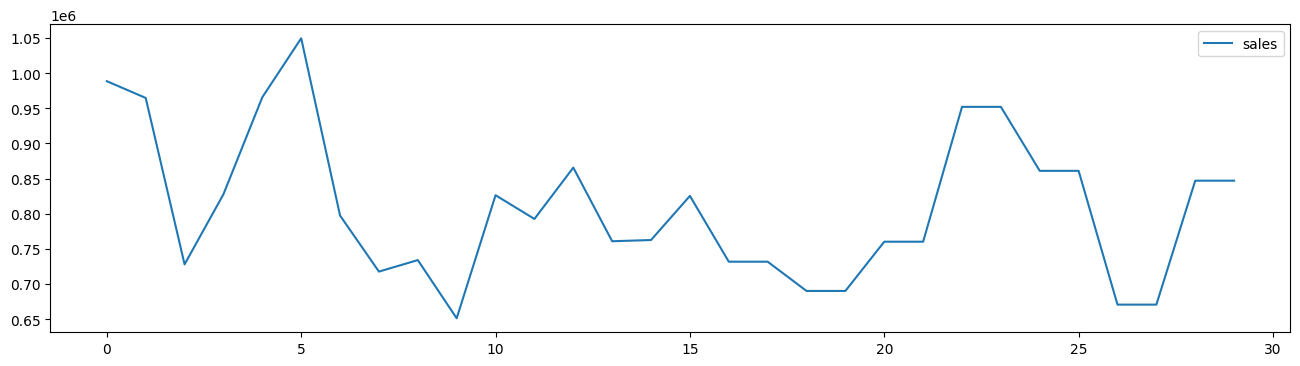

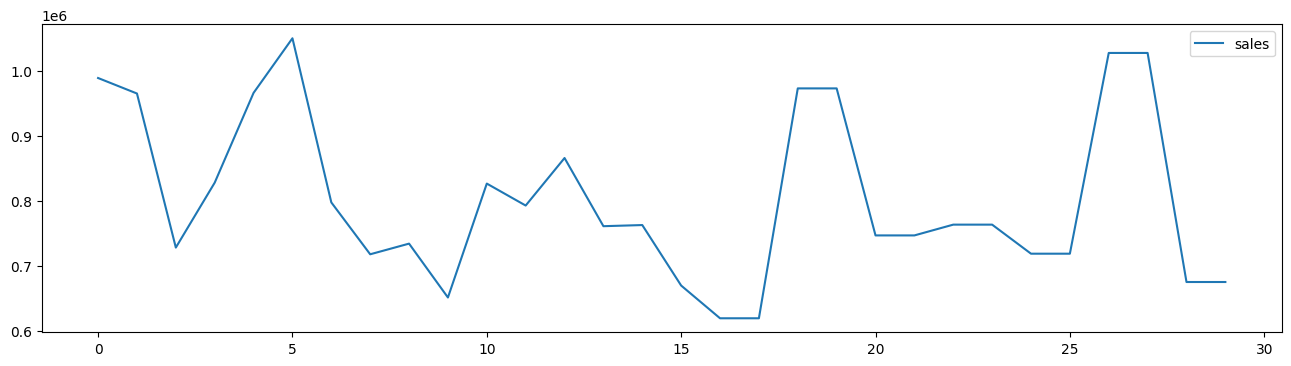

In [584]:
# Si nota dai grafici (MLP e regressore lineare rispettivamente) che l'MLP prevede picchi piu' piccoli rispetto al regressore
mlp_forecasted_df.plot(figsize=(16,4))
linear_regressor_forecasted_df.plot(figsize=(16,4))

### ARIMA model

Il modello ARIMA (Auto Regressive Integrated Moving Average) e' tra i modelli piu' indicati per il task di Time Series Forecasting in quanto studia in maniera accurata la series temporale e le sue componenti, di fatto l'unica cosa richiesta per effettuare il tuning del modello sono 3 hyper parametri.

Tali parametri sono:

- p : l'ordine auto regressivo
- d : l'ordine differenziale
- q : l'ordine della moving average

L'ordine dei parametri del modello e' (p,d,q)

Tali parametri sono stati accennati in precedenza, all'inizio del notebook, dove ho mostrato la scomposizione della serie temporale in componenti

Con tale comando installo l'oggetto pmdaria, necessario per utilizzare il modello ARIMA in quanto non risulata presente tra i pacchetti installati di default sulla piattaforma Google Colab.

Ho usato il package manager pip in base alle indicazioni presenti sulla documentazione della pattaforma setessa, nonostante conda sia il package manager piu' indicato per l'installazione e gestione delle dipendenze per ambienti per la Data Science

In [585]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [586]:
# Importo gli oggetti necessari per utilizzare il modello ARIMA
import statsmodels.api as sn
from statsmodels.tsa.arima.model import ARIMA

# Effettuo un reshape dei dati in quanto l'oggetto ARIMA richiede dati uni-dimensionali
X_train = X_train.reshape(1198,)


# Qui importo l'ogetto pmdarima per ottenere in maniera automatizzata tramite l'algoritmo AUTO_ARIMA, i suoi parametri (p,d,q)
import pmdarima as pm
model = pm.auto_arima(X_train)
# Attenzione, l'algoritmo AUTO_ARIMA richiede del tempo per trovare i parametri ideali, non quanto il GridSearchCV dell'MLP
# Ma comunque valuta le prestazioni del modello per varie combinazioni di triple di parametri

In [587]:
# Con questo metodo mostro una descrizione del modello ARIMA con i parametri adeguati ricavati
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1198
Model:               SARIMAX(2, 1, 3)   Log Likelihood                1219.500
Date:                Tue, 30 May 2023   AIC                          -2427.000
Time:                        00:50:16   BIC                          -2396.475
Sample:                             0   HQIC                         -2415.500
                               - 1198                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2464      0.001   1033.718      0.000       1.244       1.249
ar.L2         -0.9984      0.001   -875.153      0.000      -1.001      -0.996
ma.L1         -2.0377      0.014   -149.408      0.000      -2.064      -2.011
ma.L2          1.9719      0.019    106.028      0.000       1.935       2.008
ma.L3         -0.7908      0.013    -60.268      0.000      -0.817      -0.765
sigma2         0.0077      0.000     45.158      0.000       0.007       0.008
===================================================================================
Ljung-Box (L1) (Q):                   6.08   Jarque-Bera (JB):             10972.41
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               2.91   Skew:                            -1.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [588]:
# Dall'output del metodo chiamato in precedenza si evince che i parametri ideali del modello sono (2,1,3), dunque p = 2, d = 1 e q = 3
# Inoltre studiando il modello e guardando altri esempi di ARIMA con altri datasets ho visto che normalmente il parametri d ha il valore 1
# Infatti una alternativa all'algoritmo AUTO_ARIMA puo' essere la creazione manuale di triple di parametri e valutare manualmente le prestazioni del
# Modello, potrebbe essere una alternativa valida quando, avendo molta esperienza, si conoscono gia' le triple di parametri che di norma hanno
# prestazioni ottimali
model = sn.tsa.arima.ARIMA(X_train, order=(2,1,3))

In [589]:
# In questa cella effettuo le previsioni sul trainig set e ne valuto il fit
import warnings
warnings.filterwarnings('ignore')

model = model.fit()
arima_train_predictions = model.predict(start=0,end=1197)

In [590]:
if Y_train.shape[0] == 599:  
  Y_train = Y_train.reshape(1198,)

In [591]:
arima_train_predictions = arima_train_predictions.reshape(-1,1)
unscaled_predictions = scaler.inverse_transform(arima_train_predictions)

arima_train_frame = train[2:]
arima_train_frame['predictions'] = unscaled_predictions

MAE_arima_train = mean_absolute_error(train[2:],unscaled_predictions)
print("MAE on train set:\t{:.3f}".format(mean_absolute_error(train[2:],unscaled_predictions)))

MAE on train set:	139880.229


Il MAE del modello ARIMA risulta essere migliore dell'MLP (ma non questo non e' sorprendente) tuttavia il fit e' peggiore rispetto al regressore lineare, e questa informazione inaspettata e' al quanto sorprendente

<Axes: >

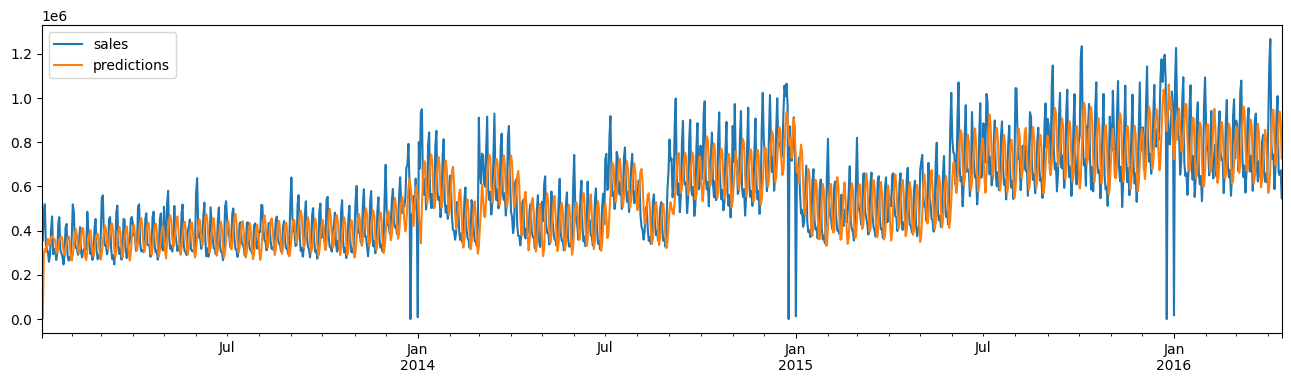

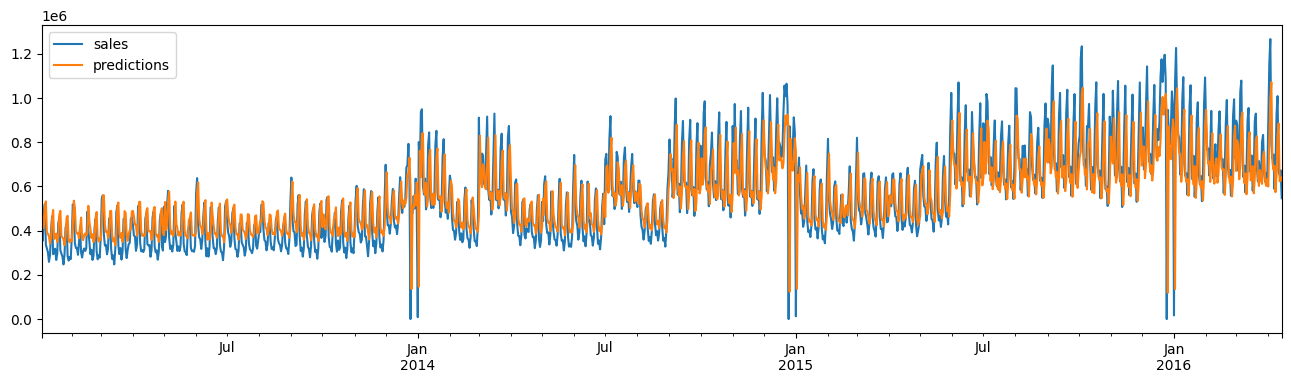

In [592]:
# Sebbene il modello ARIMA abbia un fit peggiore rispetto al regressore lineare, cio' non e' rilevabile dai grafici
arima_train_frame.plot(figsize=(16,4))
train_frame.plot(figsize=(16,4))

In [593]:
# Adesso procedo con il fit del test set in quanto 
# model = sn.tsa.arima.ARIMA(X_train, order=(2,1,3))

# model = model.fit()
# test_predictions = model.predict(start=0,end=485)
arima_test_predictions = model.predict(start=1198,end=1683)

In [594]:
arima_test_predictions = arima_test_predictions.reshape(-1,1)
unscaled_predictions = scaler.inverse_transform(arima_test_predictions)

arima_test_frame = test[2:]
arima_test_frame['predictions'] = unscaled_predictions

MAE_arima_test = mean_absolute_error(test[2:],unscaled_predictions)
print("MAE on test set:\t{:.3f}".format(mean_absolute_error(test[2:],unscaled_predictions)))

MAE on test set:	191269.115


<Axes: >

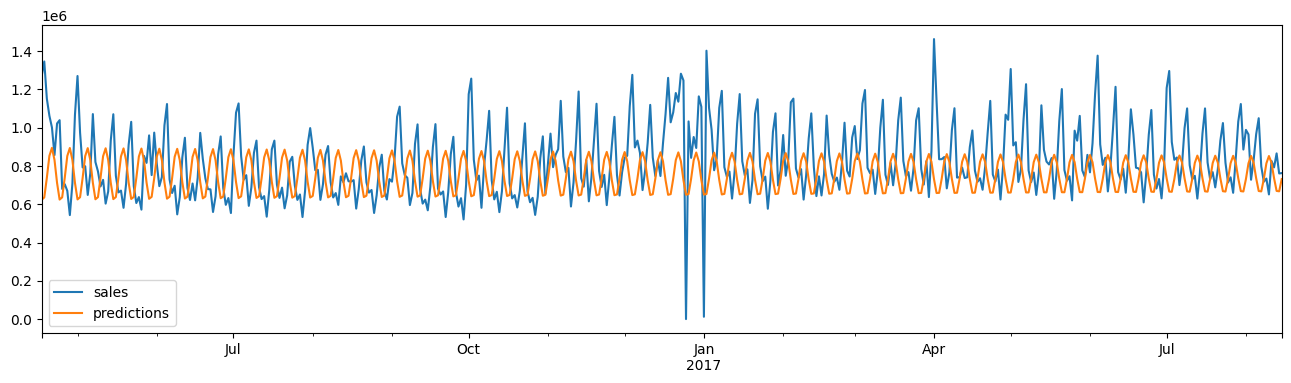

In [595]:
arima_test_frame.plot(figsize=(16,4))

Ripercorrendo gli stessi passi svolti in precedenza ho trovato che il modello ARMIA ottiene delle performance pessime con una MAE superiore all'MLP e regressore in quanto i valori forecasted tendono ad un valore medio

Dunque l'unico modo per ottenere un forecast quantomento affidabile e' quello di addestrare il modello sull'intero dataset e successivamente effettuare il forecast

In [596]:
# Rinomino l'intero dataset per comodita' ed effettuo nuovamento lo scaling
X_total = comp.values
X_total = X_total.reshape(-1,1)
X_total = scaler.transform(X_total)

model = sn.tsa.arima.ARIMA(X_total, order=(2,1,3))

model = model.fit()
arima_forecast_predictions = model.predict(start=0,end=1683)

In [597]:
# Qui effettuo il forecast con il modello ARIMA con lo stesso meccanismo visto in precedenza
last_train_batch = X_total[-15:]

arima_forecasted_predictions = []

for i in range(15):
    current_pred = []
    current_pred.append(model.predict(start=1684+i,end=1684+i))
    arima_forecasted_predictions.append(current_pred[0][0])
    first_eval_batch = last_train_batch[1:]
    first_eval_batch = np.concatenate((first_eval_batch, [current_pred[0]]))

In [598]:
# Queste sono le previsioni ottenute con il modello ARIMA
arima_forecasted_predictions

[0.7255167609789306,
 0.7255809686740069,
 0.6738344785402559,
 0.5796356685177814,
 0.5334412947984647,
 0.5396297455300407,
 0.5987759359172528,
 0.6658525886821224,
 0.6909554681208887,
 0.6564087633448289,
 0.5891517337322627,
 0.5397739561109811,
 0.544483951054694,
 0.5985859013875584,
 0.6608714858130302]

In [599]:
august_df = ndf['2017-08-01':]

print(august_df)

arima_forecasted_predictions = np.array(arima_forecasted_predictions)

arima_forecasted_predictions = arima_forecasted_predictions.reshape(-1,1)
arima_forecasted_predictions = scaler.inverse_transform(arima_forecasted_predictions)

# Effettuo un typecast altrimenti la creazione del dataframe rammenta il fatto che arima_forecasted_predictions sia un ndarray nonostante sia monodimensionale
arima_forecasted_predictions = arima_forecasted_predictions.tolist()
arima_f_list = []
for i in arima_forecasted_predictions:
  arima_f_list.append(i[0])

index = pd.date_range(start='2017-08-16', end='2017-08-30', freq='D')
f_pairs = pd.DataFrame(index=index, data={'sales':arima_f_list})
arima_forecasted_df = pd.concat([august_df, f_pairs], ignore_index=False)

                sales
date                 
2017-08-01   988527.0
2017-08-02   964712.0
2017-08-03   728068.0
2017-08-04   827775.0
2017-08-05   965693.0
2017-08-06  1049559.0
2017-08-07   797464.0
2017-08-08   717766.0
2017-08-09   734139.0
2017-08-10   651386.0
2017-08-11   826373.0
2017-08-12   792630.0
2017-08-13   865639.0
2017-08-14   760922.0
2017-08-15   762661.0


<Axes: >

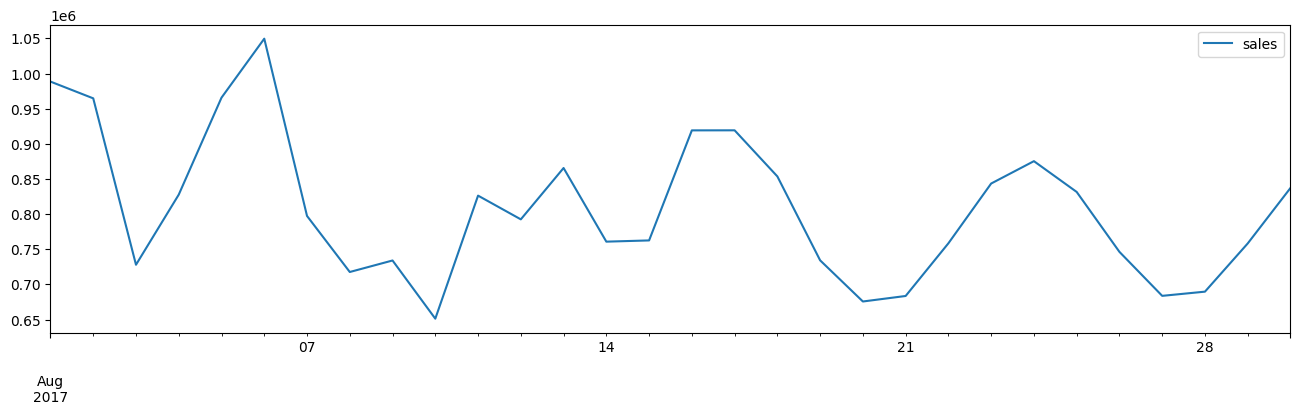

In [600]:
# Dal grafico si evince che il modello ARIMA crea una curva piu' verosimile alla serie temporale sebbene abbia il problema di essere inaccurato per 
# Previsioni a lungo termine, credo che non sia una coincidenza che il task kaggle richiedesse un forecast di soli 15 giorni
arima_forecasted_df.plot(figsize=(16,4))

Dunque la debbolezza di tale modello, in base a quanto visto dai miei esperimenti e' che esso e' sensibile ai dati presi in input e dopo qualche previsione, queste tendono a decadere e convergere verso una media, per questo il forecast va' fatto per un numero relativamente piccolo di giorni.

Tale debbolezza tuattavia non e' presente nel modello LSTM, in quanto grazie ai suoi cell states evita il problema della weight decay, classico problema delle Reti Neurali Ricorrenti.

### LSTM model

La Long Short Term Memory o LSTM e' un particolare tipo di rete neurale, ovvero una rete neurale ricorrente (Recurrent Neural Network), ideale modello da usare quando si trattano dati di natura temporale come le Time Series

Ma perche' questa rete neurale rispetto ad una normale RNN?
Perche' le RNN soffrono del problema della weight decay causata dalla modifica apportata ai pesi tramite l'algoritmo di discesa del gradiente, dunque mantenendo uno stato per ogni nurone, tale problema di decadenza dei pesi viene evitato.

In [601]:
# Effettuo nuovamente l'import delle librerie e dei dati applicando le steese procedure per il pre processing
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

df = pd.read_csv("/content/drive/MyDrive/train.csv", parse_dates=True, index_col='date')
df = df.drop(['id','store_nbr','family','onpromotion'], axis=1)
df = df.groupby('date').sum()
df = df['sales'].apply(np.floor)
df.head()

date
2013-01-01      2511.0
2013-01-02    496092.0
2013-01-03    361461.0
2013-01-04    354459.0
2013-01-05    477350.0
Name: sales, dtype: float64

In [602]:
ndf = pd.DataFrame(df)

In [603]:
one_year = ndf['2017-01-01':]
one_year

sales
date                 
2017-01-01    12082.0
2017-01-02  1402306.0
2017-01-03  1104377.0
2017-01-04   990093.0
2017-01-05   777620.0
...               ...
2017-08-11   826373.0
2017-08-12   792630.0
2017-08-13   865639.0
2017-08-14   760922.0
2017-08-15   762661.0

[227 rows x 1 columns]

In [604]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [605]:
result = ndf['sales'].resample('MS').sum()

In [606]:
result = one_year['sales'].resample('D').sum()
index = pd.date_range(start='2017-01-01', end='2017-08-15', freq='D')
one_comp = pd.DataFrame(index=index,data={'sales':result.values})
one_components = seasonal_decompose(one_comp['sales'],model='additive')

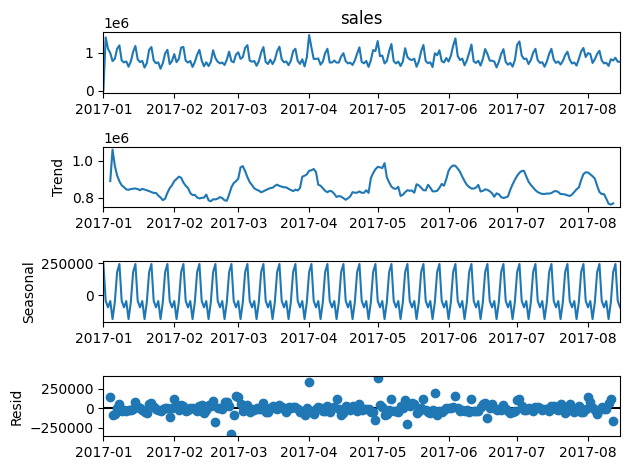

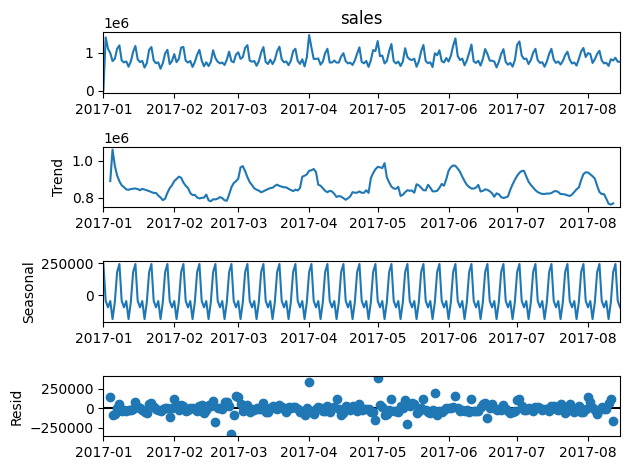

In [607]:
one_components.plot()

In [608]:
# Nel caso dell'LSTM effettuo il training solamente sui dati ottenuti durante il 2017
train = one_year['2017-01-01':'2017-05-31']
test = one_year['2017-06-01':'2017-08-15']

In [609]:
# Applico lo scaler nuovamente sui dati
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Effettuo nuovamente il fit dello scaler
scaler.fit(train)

MinMaxScaler()

In [610]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [611]:
# Create a generator to create input/output pairs to feed to the windowed function
from keras.preprocessing.sequence import TimeseriesGenerator

# might need to change the input
n_input = 12
n_features = 1
# Creates input/output pairs
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [612]:
X,y = generator[0]

In [613]:
X

array([[[0.        ],
        [0.95811374],
        [0.75278721],
        [0.67402504],
        [0.52759302],
        [0.57030836],
        [0.75239369],
        [0.8135494 ],
        [0.53869157],
        [0.50348208],
        [0.52285284],
        [0.42560481]]])

In [614]:
y

array([[0.521582]])

Non ho commentato alcune operazioni svolte in precedenza in quanto le stesse rispetto all'inizio del notebook, salvo qualche eccezzione dove ho aggiunto commenti

In [615]:
# Effettuo l'import delle librerie dovute importando i vari oggetti richiesti, tra cui l'API sequenziale, i layers LSTM e Dense, l'ottimizzatore Adam, che utilizza
# Una versione stocastica dell'algoritmo della discesa del gradiente
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

In [616]:
# In questa cella definisco il modello LSTM, ho scelto l'approccio consigliato in merito all'architettura della rete neurale, ovvero usando un modello 'a cono', ovvero
# Che va a restringersi man mano
model = Sequential()
# model.add(LSTM(70, activation='tanh', return_sequences=True, input_shape=(n_input,n_features)))
model.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=(n_input,n_features)))
# model.add(LSTM(60, activation='tanh', return_sequences=True))
# model.add(LSTM(50, activation='tanh', return_sequences=True))
# model.add(LSTM(40, activation='tanh', return_sequences=True))
# model.add(LSTM(30, activation='tanh', return_sequences=True))
# model.add(LSTM(20, activation='tanh'))
model.add(LSTM(50, activation='tanh'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# FANTASTIC RESULTS with 60 - 50 - 50 - 50 - 60 and 60 - 50 - 40 - 30 - 20

In [617]:
# Tale metodo descrive brevemente l'architetture e la cardinalita' dei parametri del modello
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 12, 100)           40800     
                                                                 
 lstm_15 (LSTM)              (None, 50)                30200     
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [618]:
# Con tale metodo si effettua l'effettivo fit del modello, usando il risultato dell'oggetto Time Series Generator usato in precedenza nel notebook
model.fit(generator, epochs=100)

Epoch 1/100
139/139 [==============================] - 15s 30ms/step - loss: 0.0264
Epoch 2/100
139/139 [==============================] - 4s 25ms/step - loss: 0.0168
Epoch 3/100
139/139 [==============================] - 3s 22ms/step - loss: 0.0163
Epoch 4/100
139/139 [==============================] - 4s 25ms/step - loss: 0.0184
Epoch 5/100
139/139 [==============================] - 3s 20ms/step - loss: 0.0162
Epoch 6/100
139/139 [==============================] - 2s 12ms/step - loss: 0.0153
Epoch 7/100
139/139 [==============================] - 2s 11ms/step - loss: 0.0152
Epoch 8/100
139/139 [==============================] - 3s 19ms/step - loss: 0.0174
Epoch 9/100
139/139 [==============================] - 3s 19ms/step - loss: 0.0150
Epoch 10/100
139/139 [==============================] - 2s 12ms/step - loss: 0.0149
Epoch 11/100
139/139 [==============================] - 2s 12ms/step - loss: 0.0153
Epoch 12/100
139/139 [==============================] - 2s 12ms/step - loss: 0.0141


In [619]:
# Monitorando la loss ottenuta durante il traning concludo che 100 epoche siano sufficienti per ottenere un buon fit del modello, riporto dai miei esperimenti che aumentare le epoche
# Del training comporta una instabilita' durante il training ed un inevitabile fit sgradevole da parte del modello
# Aggiungo che sebbene le LSTM siano usate con architetture deep, dunque nella affascinante disciplina del deep learning, ammetto che il mio utilizzo in questo progetto si 
# al quanto elementare e induco dai miei studi che normalmente per i task di Time Series Forecasting l'utilizzo di Reti Neurali profonde non sia necessario
# Gli esperimenti condotti con gli strati commentati confermano quanto detto
loss_per_epoch = model.history.history['loss']
loss_per_epoch

[0.02637775056064129,
 0.016814174130558968,
 0.016291700303554535,
 0.018360156565904617,
 0.01618918403983116,
 0.015288939699530602,
 0.015204519033432007,
 0.017353558912873268,
 0.014955587685108185,
 0.014869443140923977,
 0.01533264946192503,
 0.014066413044929504,
 0.011509065516293049,
 0.009970416314899921,
 0.009494701400399208,
 0.008846398442983627,
 0.008088428527116776,
 0.009343849495053291,
 0.007590575143694878,
 0.009308404289186,
 0.007656823843717575,
 0.008227144367992878,
 0.007825820706784725,
 0.0070447977632284164,
 0.007803908549249172,
 0.00790958572179079,
 0.007474993821233511,
 0.007519738283008337,
 0.0070579093880951405,
 0.007453978527337313,
 0.007244551088660955,
 0.007221536710858345,
 0.0067129917442798615,
 0.006603374145925045,
 0.007171319797635078,
 0.007202357053756714,
 0.0069716149009764194,
 0.006455432157963514,
 0.0072457874193787575,
 0.006714086979627609,
 0.006310383323580027,
 0.006613655015826225,
 0.0066123534925282,
 0.006704452913

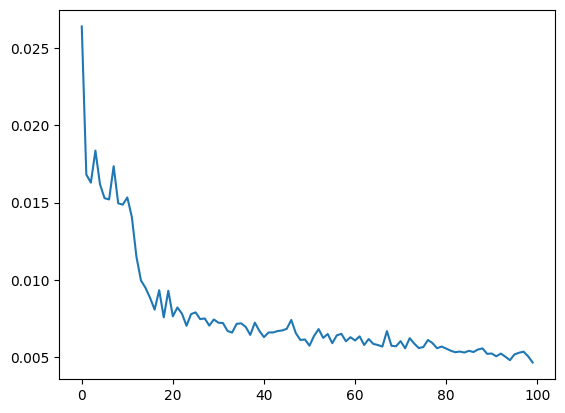

In [620]:
# In questa cella plotto la variazione della curva di loss lungo le varie epoche del training
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [621]:
# Effettuo per l'LSTM la stesso operazione windowed per ottenere sia le previsioni sul training e test set che per il forecast vero e proprio
last_train_batch = scaled_train[-12:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [622]:
# Ottengo le vere e proprie previsioni
model.predict(last_train_batch)

1/1 [==============================] - 1s 809ms/step


array([[0.50810695]], dtype=float32)

In [623]:
scaled_test[0]

array([0.52017676])

In [624]:
train_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

# Continuously updates the (sliding) time window for the predictions
for i in range(len(train)):
    current_pred = model.predict(current_batch)[0]
    train_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 28ms/step


In [625]:
# scale back to the original value range
true_predictions = scaler.inverse_transform(train_predictions)

In [626]:
# sneak peek at the predictions vs ground truth values
print(true_predictions)

train['predictions'] = true_predictions
train.head()

[[ 749345.68812442]
 [ 891146.1936177 ]
 [1025294.72845769]
 [ 880669.058249  ]
 [ 787301.6281842 ]
 [ 817154.74399179]
 [ 747532.06833375]
 [ 758095.69010162]
 [ 927924.01594794]
 [ 964642.85455394]
 [ 841764.96779507]
 [ 798568.21140456]
 [ 814949.60027206]
 [ 744711.40091109]
 [ 793028.93051028]
 [ 946703.32671893]
 [ 960216.30767143]
 [ 839086.05158067]
 [ 804365.65420038]
 [ 803697.20082116]
 [ 743983.70434844]
 [ 824276.38004535]
 [ 966991.1332643 ]
 [ 940591.85180771]
 [ 822125.29032511]
 [ 808032.59103894]
 [ 791385.51595318]
 [ 743743.96404994]
 [ 850487.81304294]
 [ 980019.09849024]
 [ 915300.54761094]
 [ 809409.19505459]
 [ 812431.98119211]
 [ 777034.13584709]
 [ 750820.45420313]
 [ 879612.71336949]
 [ 985080.28256989]
 [ 891320.46371204]
 [ 802782.3476907 ]
 [ 814929.88137305]
 [ 763029.73917449]
 [ 764717.43476796]
 [ 908564.55441129]
 [ 981554.57802117]
 [ 868070.23853576]
 [ 800378.89065766]
 [ 813871.97973835]
 [ 751314.11856961]
 [ 783835.94519651]
 [ 934854.17111373]


sales   predictions
date                               
2017-01-01    12082.0  7.493457e+05
2017-01-02  1402306.0  8.911462e+05
2017-01-03  1104377.0  1.025295e+06
2017-01-04   990093.0  8.806691e+05
2017-01-05   777620.0  7.873016e+05

In [627]:
# Ottengo il MAE sul training set
from sklearn.metrics import mean_absolute_error
MAE_train_lstm = mean_absolute_error(train['sales'],train['predictions'])
print("MAE:\t{}".format(MAE_train_lstm))

MAE:	135901.3224699805


<Axes: xlabel='date'>

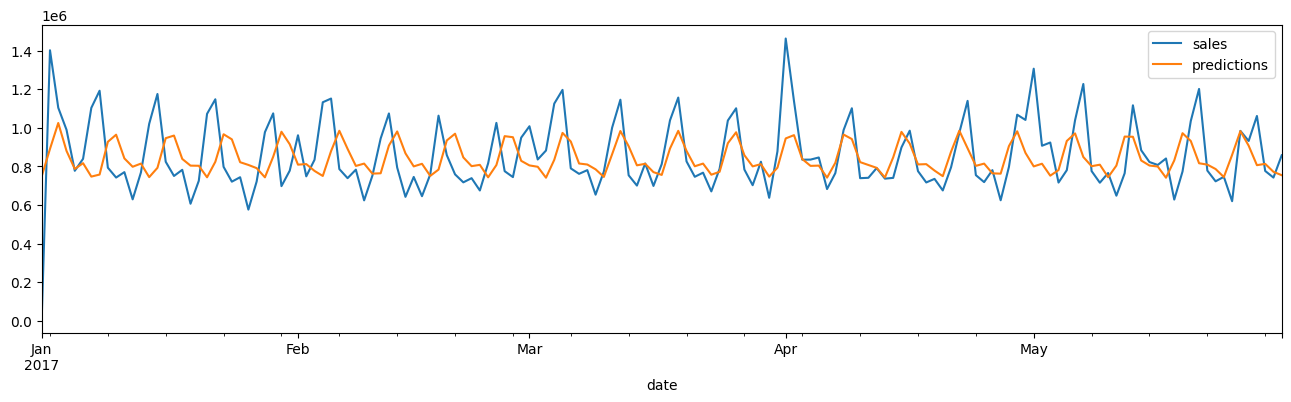

In [628]:
# Dal plot delle prestazioni del training set si evince che il fit non sia perfetto, tuttavia il modello apprende i trends e la stagionalita' senza problemi
train.plot(figsize=(16,4))

In [629]:
# Adesso valuto la performance con il test set
last_test_batch = scaled_test[-12:]
last_test_batch = last_test_batch.reshape((1, n_input, n_features))

In [630]:
# Effettuo nuovamente le operazioni windowed
test_predictions = []
first_eval_batch = scaled_test[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred[0])
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 50ms/step


In [634]:
test_predictions = np.array(test_predictions)
test_predictions = test_predictions.reshape(-1,1)
true_predictions = scaler.inverse_transform(test_predictions)

In [635]:
test['predictions'] = true_predictions
test.head()

sales  predictions
date                              
2017-06-01   766859.0  789555.2500
2017-06-02   918421.0  749446.3125
2017-06-03  1176138.0  843830.8750
2017-06-04  1376511.0  963155.6250
2017-06-05   912693.0  915134.1250

In [637]:
# Ed infine valuto la performance sul test set
MAE_test_lstm = mean_absolute_error(test['sales'],test['predictions'])
print("MAE:\t{}".format(MAE_test_lstm))

MAE:	97858.89391447368


<Axes: xlabel='date'>

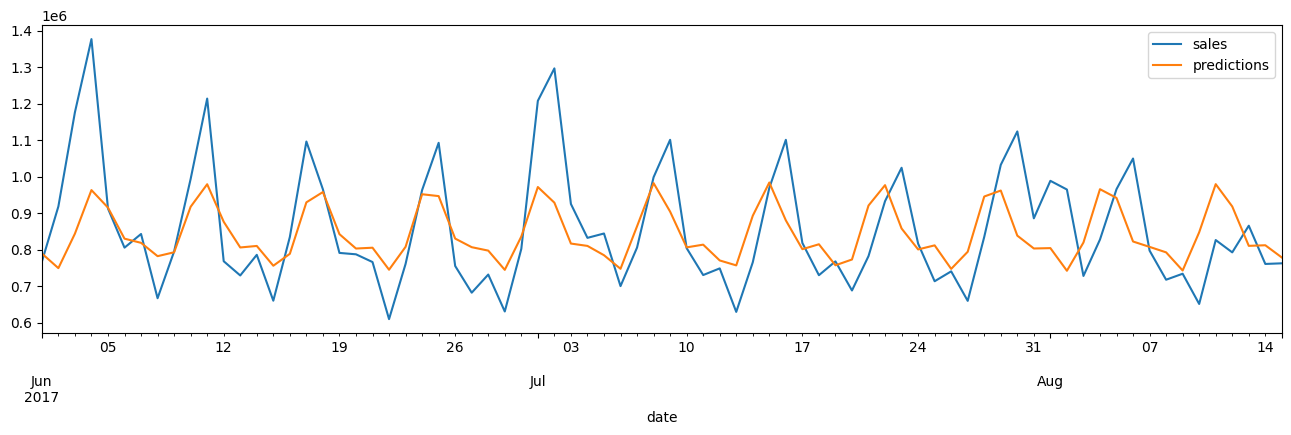

In [638]:
test.plot(figsize=(16,4))

Si nota che il MAE e' piu' elevato sul training set che sul test set e tale fenomeno e' probabilmente dovuto al relativamente piccolo numero di campioni usati per il test set, in quanto anche nel test set non si ottiene un fit ideale

In [639]:
# Effettuo il forecast con l'LSTM
forecast = []
first_eval_batch = scaled_test[-15:]
current_batch = first_eval_batch.reshape((1, 15, n_features))

for i in range(15):
    current_pred = model.predict(current_batch)[0]
    forecast.append(current_pred[0])
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 36ms/step


In [640]:
# 15 day forecast
forecast

[0.53833485,
 0.53582805,
 0.6310197,
 0.7249893,
 0.6560912,
 0.5610143,
 0.55790365,
 0.5205338,
 0.5720501,
 0.69193065,
 0.7015568,
 0.5736879,
 0.538994,
 0.5444886,
 0.49699813]

In [641]:
# Effettuo la creazione del dataframe e ottengo i dati con valori assoluti
august_df = ndf['2017-08-01':]

august_dates = pd.date_range(start='2017-08-01', end='2017-08-15', freq='D')
august_sales = august_df.values

scaled_data = scaler.transform(august_sales)
august_sales = [item for tuple in scaled_data for item in tuple]

august_sales = august_sales + forecast

print(august_sales)
index = pd.date_range(start='2017-08-01', end='2017-08-30', freq='D')
lstm_forecasted_df = pd.DataFrame(index=index, data={'sales':august_sales})

[0.6729457801889868, 0.6565329727546707, 0.4934428025893849, 0.5621588131228028, 0.6572090577470312, 0.71500777738954, 0.5412690962997269, 0.4863428764004987, 0.49762681073272863, 0.4405951477635095, 0.5611925836026302, 0.5379376030753942, 0.5882539019614735, 0.5160851026291505, 0.517283585607453, 0.53833485, 0.53582805, 0.6310197, 0.7249893, 0.6560912, 0.5610143, 0.55790365, 0.5205338, 0.5720501, 0.69193065, 0.7015568, 0.5736879, 0.538994, 0.5444886, 0.49699813]


<Axes: >

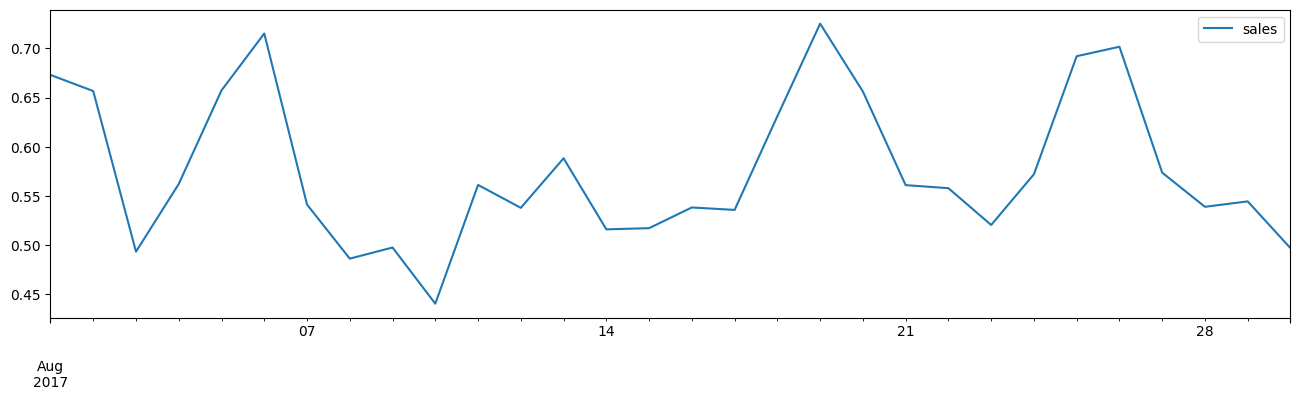

In [642]:
# Dal grafico del forecast si evince come apparentemente ci sia una curva migliore ma questo non implica che le previsioni siano piu' 
# attendibili in quanto training e test set presentano una MAE non indifferente
lstm_forecasted_df.plot(figsize=(16,4))

Dunque, con questo progetto sono stati analizzate le performance predittive di 4 modelli diversi, in ordine, Regressore, MLP, ARIMA ed LSTM, di seguito sono riportati i forecasts dei seguenti modelli.

<Axes: >

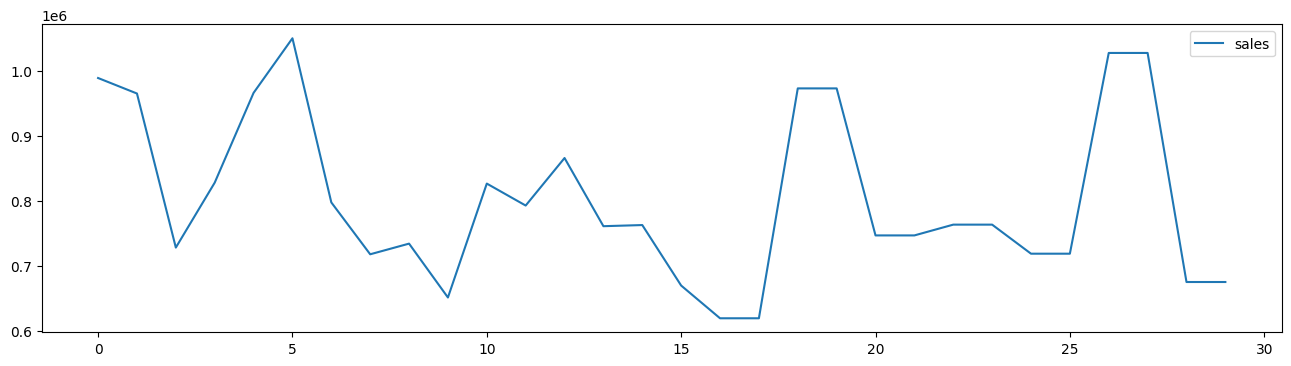

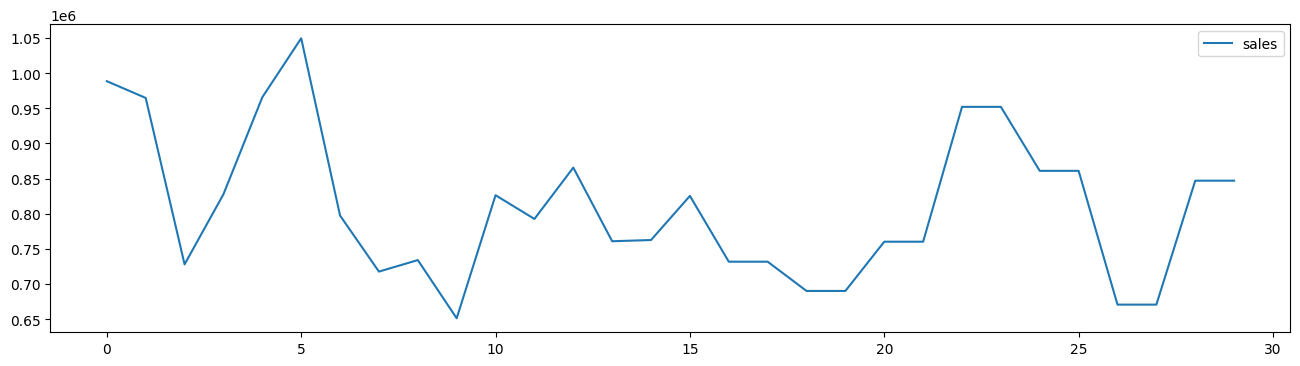

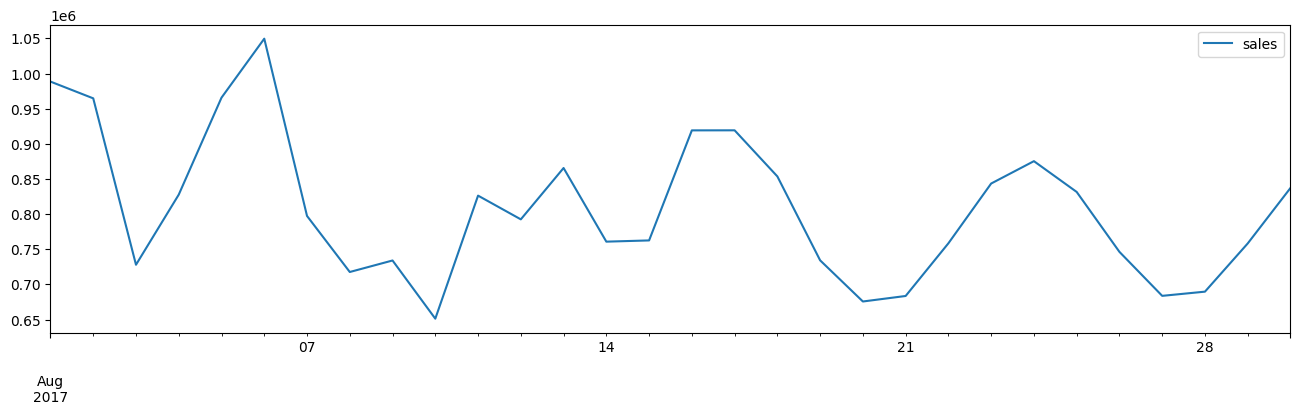

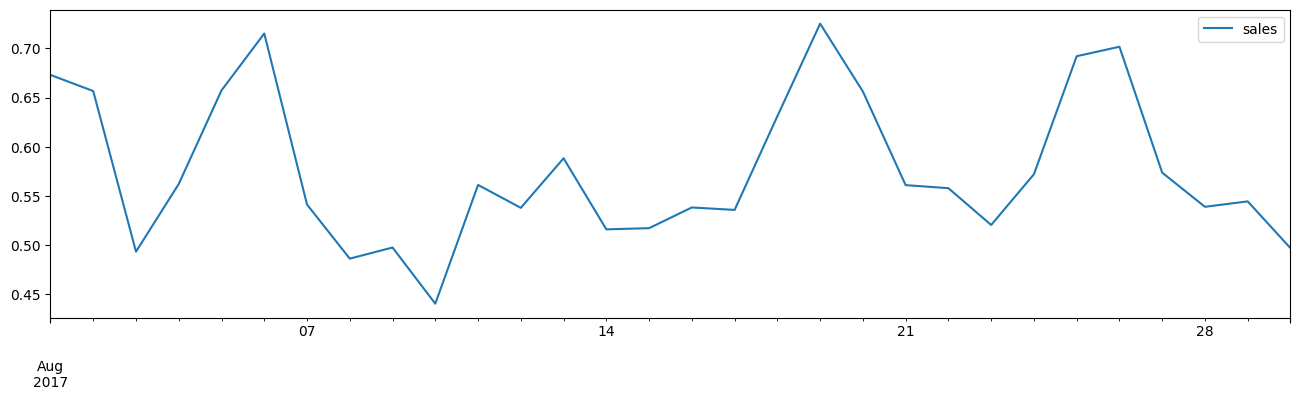

In [643]:
# Nel grafico si riportano i vari forecasts differenti ottenuti dai diversi modelli e le loro rispettive curve, per conoscere l'effettivo successo da parte
# del modello occorre studiare la sua performance avendo ottenuti i dati, tuttavia non avendo tali dati, la qualita' del modello si evince dalla sua performance
# su training e test set
linear_regressor_forecasted_df.plot(figsize=(16,4))
mlp_forecasted_df.plot(figsize=(16,4))
arima_forecasted_df.plot(figsize=(16,4))
lstm_forecasted_df.plot(figsize=(16,4))

<Axes: xlabel='date'>

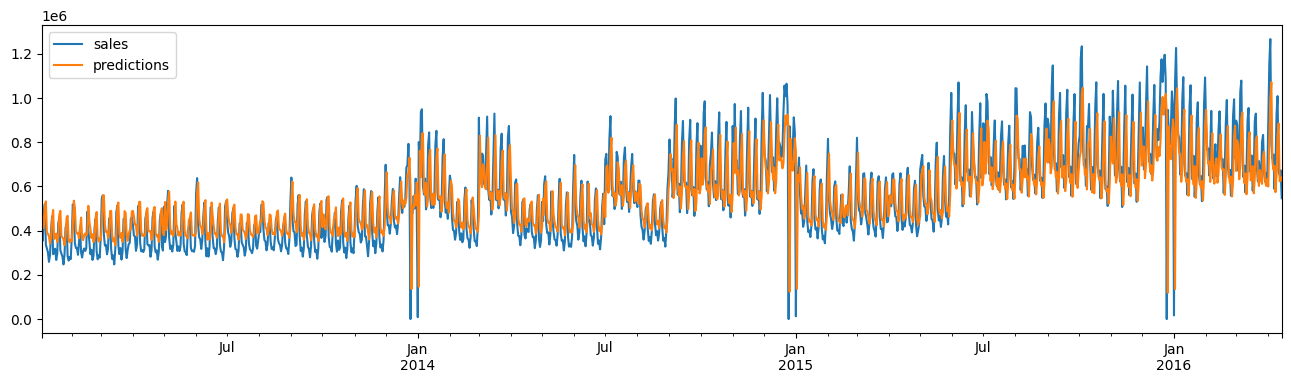

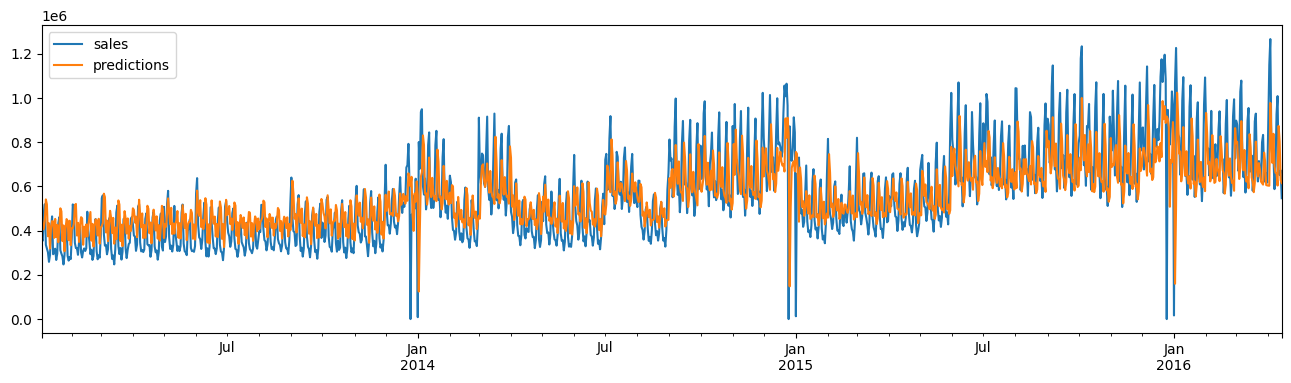

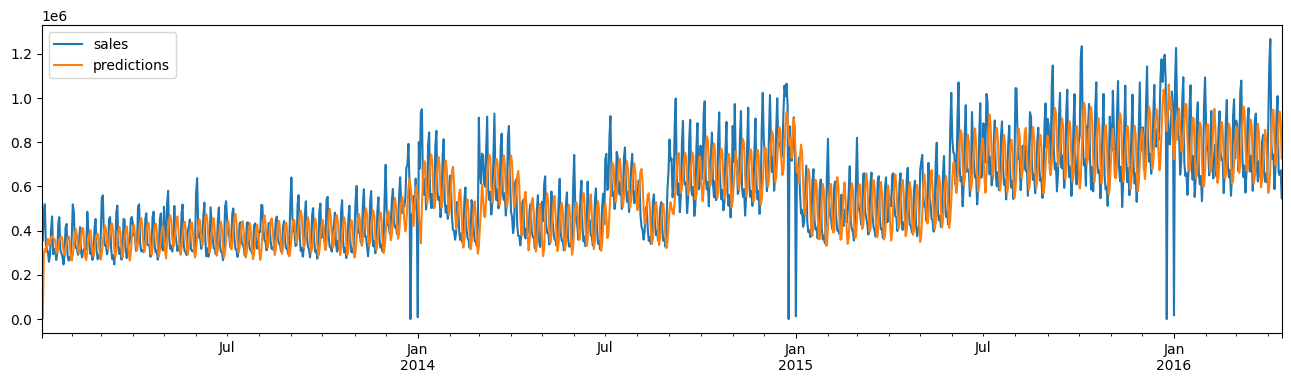

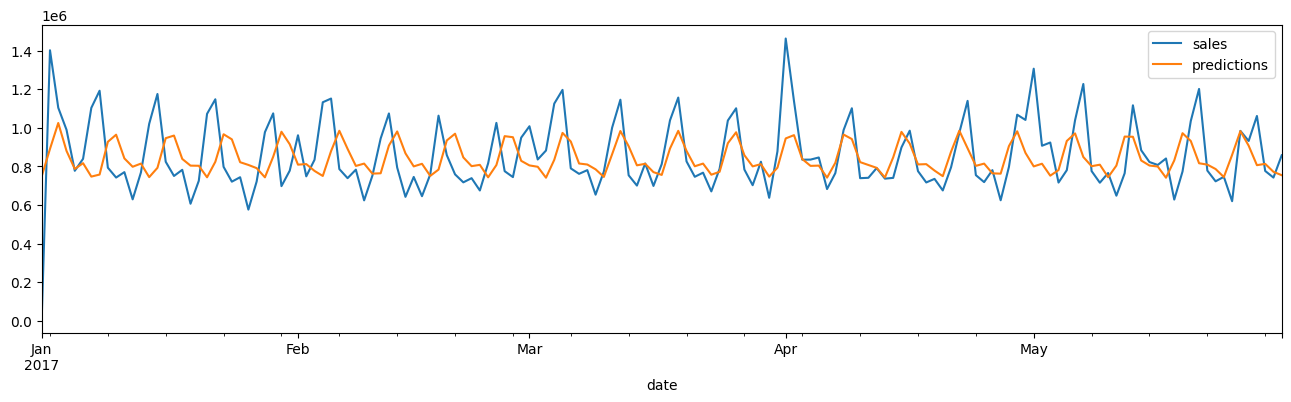

In [644]:
# Di seguito riporto i grafici delle prestazioni dei modelli sul training set, riportati in ordine di utilizzo del modello
train_frame.plot(figsize=(16,4))
mlp_train_frame.plot(figsize=(16,4))
arima_train_frame.plot(figsize=(16,4))
train.plot(figsize=(16,4))

<Axes: xlabel='date'>

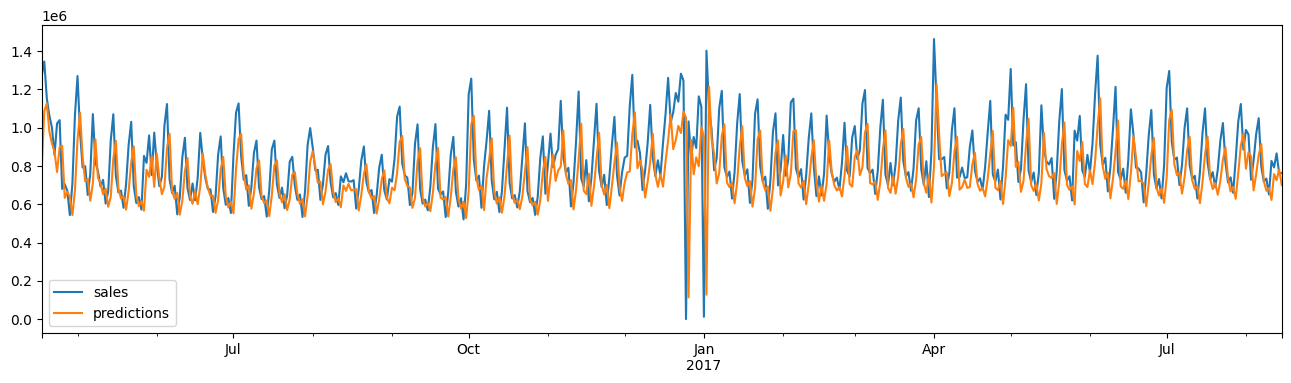

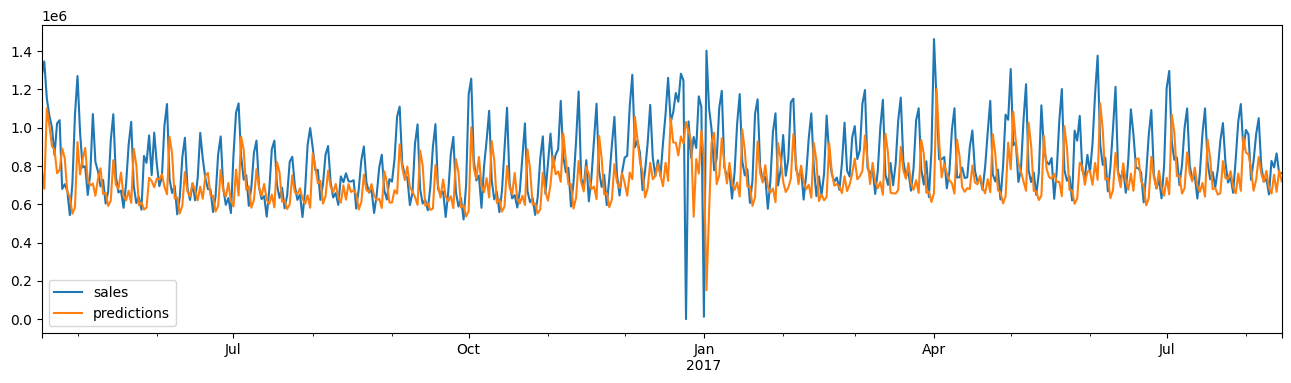

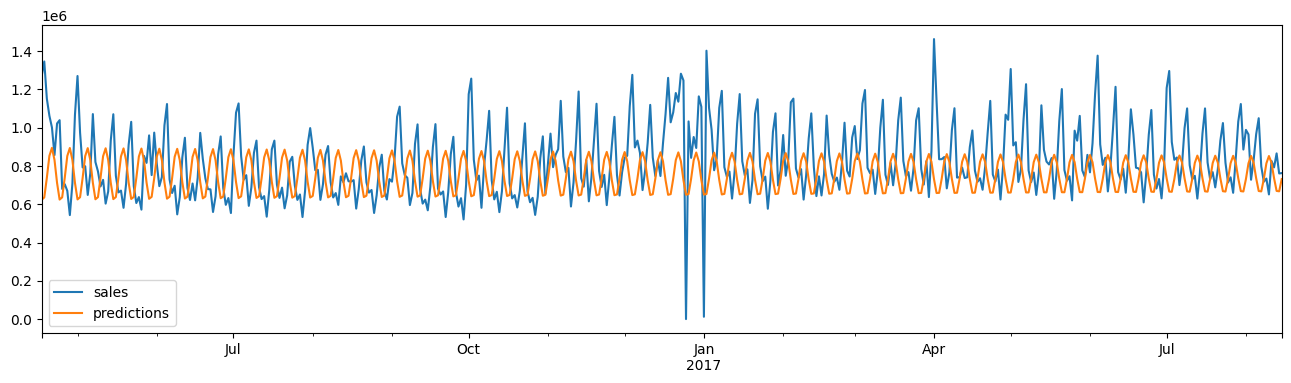

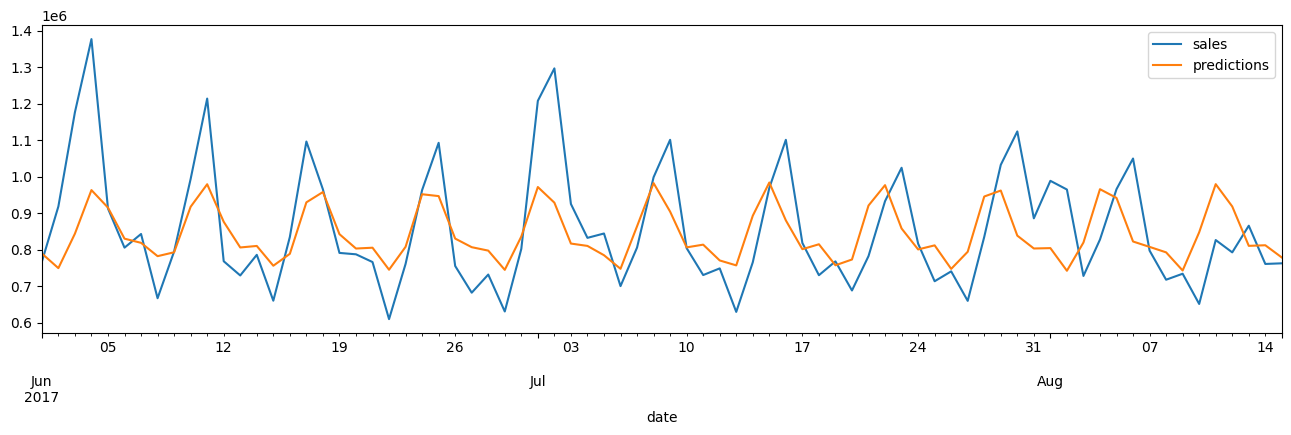

In [645]:
# Di seguito riporto i grafici sulle prestazioni sul test set da parte dei modelli
test_frame.plot(figsize=(16,4))
mlp_test_frame.plot(figsize=(16,4))
arima_test_frame.plot(figsize=(16,4))
test.plot(figsize=(16,4))

In [650]:
# In questa cella riporto i MAE dei diversi modelli, per avere un confronto piu' immediato
MAE_train_frame = pd.DataFrame(index=[0],data={'LinearRegressor':MAE, 'PolynomialRegressor':MAE_train_poly, 'MLP':MAE_mlp_train, 'ARIMA':MAE_arima_train, 'LSTM':MAE_train_lstm})
MAE_train_frame

LinearRegressor  PolynomialRegressor            MLP          ARIMA  \
0    106037.576862         96616.133233  121157.570865  139880.228813   

           LSTM  
0  135901.32247

Il MAE piu' basso e' del RegressorePolinomiale

In [651]:
# MAE sul test set
MAE_test_frame = pd.DataFrame(index=[0],data={'LinearRegressor':MAE_test, 'PolynomialRegressor':MAE_test_poly, 'MLP':MAE_mlp_test, 'ARIMA':MAE_arima_test, 'LSTM':MAE_test_lstm})
MAE_test_frame

LinearRegressor  PolynomialRegressor            MLP         ARIMA  \
0    150520.541499        113249.581148  161654.319934  191269.11549   

           LSTM  
0  97858.893914

Il MAE piu' basso sul test set appartiene all'LSTM ma sospetto che sia a causa dei pochi dati, dunque il secondo modello con il MAE piu' basso e' il 
regressore polinomiale

### Conclusioni

In base a quanto visto nel progetto e in base al training e ai parametri usati
nei modelli, concludo che il modello migliore per effettuare la time series forecasting sia un regressore polinomiale in quanto e' un modello semplice
e si addice perfettamente al contesto in quanto i modelli ARIMA ed LSTM, sebbene anch'essi molto usati per le previsioni di serie temporali, vengono usati con molte piu' features e con use cases piu' complessi dove naturalmente,un regressore non potra' performare allo stesso modo (il nostro dataset con 1 feature)
<br><br><br>
Fine progetto del corso di Social Media Management, anno accademico 2022-2023
<br>Studente: Andrew Ryan Darnall
<br>Matricola: 1000026223
<br>Corso di Laurea: Informatica (L-31)